# Prise en main des données

In [2]:
import pandas as pd
import numpy as np
import datetime
import warnings
import math
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import sys, os

Les dataframes sont chargées, concaténées et la variable 'Unnamed: 0' est retirée

In [3]:
df1 = pd.read_csv('datasets/df1.csv')
df2 = pd.read_csv('datasets/df2.csv')
df3 = pd.read_csv('datasets/df3.csv')
df4 = pd.read_csv('datasets/df4.csv')
df5 = pd.read_csv('datasets/df5.csv')
df6 = pd.read_csv('datasets/df6.csv')

data_frames = [df1, df2, df3, df4, df5, df6]

merged_df = pd.concat(data_frames)
merged_df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [5]:
merged_df.head()

,id,lat,long,ts
0,66,48.846460,2.306055,1556661600
1,66,48.846442,2.306054,1556661640
2,66,48.846465,2.306093,1556661690
3,66,48.846485,2.306105,1556661740
4,66,48.846450,2.306070,1556661880


In [6]:
print('nombre de lignes:', merged_df.shape[0])

nombre de lignes: 1175842


Pour avoir une vue plus simple sur les timestamps, nous ajoutons une colonne représentant le datetime sous forme YYYY-MM-DD HH:MM:SS

In [7]:
merged_df['timestamp'] = (pd.to_datetime(merged_df['ts'], unit='s'))    


In [9]:
merged_df.head()

,id,lat,long,ts,timestamp
0,66,48.846460,2.306055,1556661600,2019-04-30 22:00:00
1,66,48.846442,2.306054,1556661640,2019-04-30 22:00:40
2,66,48.846465,2.306093,1556661690,2019-04-30 22:01:30
3,66,48.846485,2.306105,1556661740,2019-04-30 22:02:20
4,66,48.846450,2.306070,1556661880,2019-04-30 22:04:40


Il n'est pas précisé si l'enregistrement GPS est continue même si le moteur est à l'arret ou non, nous allons donc le déterminer si après en calculant la différence maximale entre 2 timestamps et pour chaque vehicule.

In [10]:
def max_diff_ts():
    
    max_diff_ts = {} # initialisation d'un dictionnaire à remplir

    for vehicule in merged_df['id'].unique(): # iteration sur les id des vehicules

        diff_ts = [] # initialisation d'une list à remplir

        df_vehicule_targeted = merged_df[merged_df['id'] == vehicule] # on extrait un dataframe contenant uniquement 
        df_vehicule_targeted.sort_values(by = 'ts', inplace = True)   # l'id courant, le dataframe est ensuite ordonnée
        df_vehicule_targeted.reset_index(inplace = True)              # par timestamp

        for row in range(df_vehicule_targeted.shape[0] - 1):
            
            # Calcule du temps en minutes séparant 2 timestamps consécutifs

            diff = (df_vehicule_targeted['ts'][row+1] - df_vehicule_targeted['ts'][row]) / 60
            diff_ts.append(diff)
            
        # L'écart maximum entre 2 timestamps est ensuite extrait
        
        max_diff_ts['{}'.format(vehicule)] = max(diff_ts)

    return max_diff_ts
    
    

In [12]:
max_value = max_diff_ts()

print('Temps maximum de la perte de signal GPS: {0:.2f} min'.format(max(max_value.values())))

Temps maximum de la perte de signal GPS: 11.33 min


Au maximum, un vehicule n'a émis aucun signal GPS pendant seulement 11 minutes, nous pouvons considérer que le tracking est donc fait en continue même si le moteur est éteint.

Remarque: Cette perte de signal GPS pourrait être dû au passage du véhicule dans un tunnel par exemple

# 1.       Quelles sont les étapes du trajet du véhicule n°78 lors de la journée du 2 mai?

Nous définissons un nouveau dataframe propre au vehicule 78 sur la journée du 2 mai ordonnée dans l'ordre chronologique.

En unix epoch, le 2 mai à minuit correspond à 1556755200
et le 3 mai à minuit correspond à 1556841600

Nous définissons le concept de "étape du trajet" comme un arrêt prolongé ou un mouvement prolongé de l'ordre de quelques minutes.

In [14]:
# Création d'un dataframe filtré sur le vehicule 78 pour le 2 mai

df_78_2_mai = merged_df[(merged_df['id'] == 78) 
                        & (merged_df['ts'] >= 1556755200) # timestamp du 2 mai à minuit
                        & (merged_df['ts'] < 1556841600)] # timestamp du 3 mai à minuit

df_78_2_mai.sort_values(by = 'ts', inplace = True)
df_78_2_mai.reset_index(inplace = True, drop = True)


Nous définissons ensuite une fonction qui donne la distance séparant deux plots GPS

In [6]:
# cette fonction n'est pas de moi


def distance(origin, destination):
    lat1, lon1 = origin[0], origin[1]
    lat2, lon2 = destination[0], destination[1]
    radius = 6371000 # metres

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d



Nous calculons ensuite la distance parcourue entre deux plots GPS, c'est-à-dire entre deux lignes consécutives donc, dans l'ordre chronolique mais avec un pas de temps irregulier à cause du tracking espacé de 10 secondes lorsque le véhicule est en mouvent et environ 40 secondes lorsqu'il est à l'arrêt.

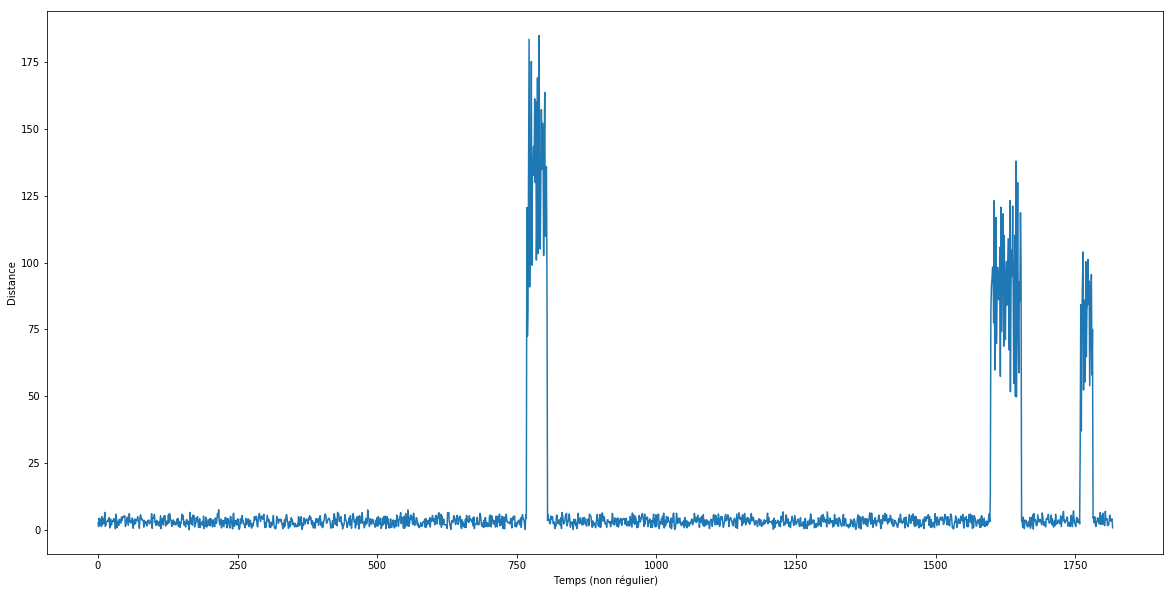

In [43]:
dist_array = []

for row in range(df_78_2_mai.shape[0] - 1):
        
    dist = distance([df_78_2_mai['lat'][row+1], df_78_2_mai['long'][row+1]], 
                    [df_78_2_mai['lat'][row], df_78_2_mai['long'][row]])
    
    dist_array.append(dist)    
        
plt.figure(figsize = (20,10))
plt.plot(dist_array)
plt.ylabel('Distance')
plt.xlabel('Temps (non régulier)')
plt.show();

Nous pouvons voir très clairement qu'il y a trois zones notables de mouvement du véhicule.

A noter un fort bruit sur le graph dû probablement à la précision du GPS.
Pour palier à ce bruit, nous allons espacer l'échelle de temps du calcul de la distance entre deux plots GPS, passant de 1 à 10 lignes, ce qui nous permettra de mieux distinguer un déplacement très lent ou une erreur dû à la précision à un arrêt.

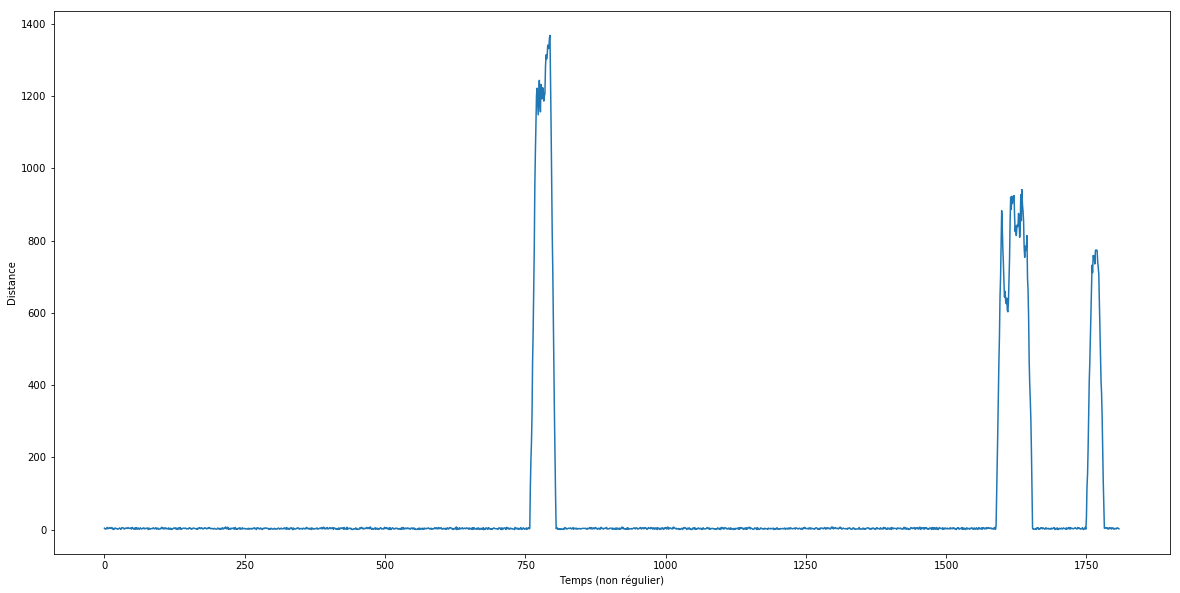

In [44]:
dist_array = []

for row in range(df_78_2_mai.shape[0] - 10):
        
    dist = distance([df_78_2_mai['lat'][row+10], df_78_2_mai['long'][row+10]], # Espacement de 10 lignes entre 2 timestamps
                    [df_78_2_mai['lat'][row], df_78_2_mai['long'][row]])       # afin de réduire le bruit
    
    dist_array.append(dist)    
        
plt.figure(figsize = (20,10))
plt.plot(dist_array)
plt.ylabel('Distance')
plt.xlabel('Temps (non régulier)')
plt.show();

La courbe est bien lissée.

Nous constatons que le véhicule est à l'arret du début du tracking du 2 mai (correspondant à la ligne zéro du dataframe filtré), c'est-à-dire 1h50 à la ligne 750 environ qui correspond à 10h15 environ.
Un check sur une carte permet de voir que la zone GPS correspond au 16ème arrondissement de Paris.

Ensuite, à partir de la 750ème ligne (10h15) le vehicule est en mouvement pendant 6 à 7 min juqu'à une localisation dans le 2ème arrondissement ce qui concorde avec le temps de trajet compte tenu de la distance.
Nous pouvons remarquer des pics et descentes sur le graph zoomé à cette période ce qui pourrait correspondre à des arrêts ponctuels à des stops ou des feux rouges par exemple.

Par la suite, à partir de la ligne 1590 correspondant à l'heure 21h25 environ, le véhicule se remet en mouvement pendant 6 à 7 minutes environ pour revenir au même endroit que le matin dans le 16ème arrondissement.

Un peu plus tard, à la ligne 1755 environ, soit 23h21 environ, le véhicule se remet en mouvement pendant 6 à 7 minutes environ. La destination atteinte correspond à une localisation dans le 7ème arrondissement.

Le véhicule ne bougera plus ensuite.


Déterminons tout cela de façon plus précise:


# A commenté

In [156]:
def nombre_stop_avec_index(data, epsilon):
    
    """epsilon représente le niveau du bruit (environ 10 mètres) et data et le pandas dataframe a traité"""

    res = [[]]
    i = 0
    indexes_stop = {}
    list_array_final = []

    for index in range(0,(data.shape[0]-1)):


            if distance([data['lat'][index+1], data['long'][index+1]], 
                            [data['lat'][index], data['long'][index]]) < epsilon:


                res[i].append(index)

            else:


                i = i + 1

                res.append([index])

    j = 0

    for i in range(len(res)):

        if len(res[i]) > 1:

            list_array_final.append(res[i])

    print("nombre d'arrets comptabilisés:", len(list_array_final), '\n \n')


    for stop in range(len(list_array_final)):
    
        indexes_stop['stop_{}'.format(stop + 1)] = [list_array_final[stop][0], list_array_final[stop][-1]]
        
        
        
    for key in indexes_stop.keys():
        
        first_ts = data['timestamp'].ix[indexes_stop[key][0]].time()
        last_ts = data['timestamp'].ix[indexes_stop[key][-1]].time()
        
        index_loc = indexes_stop[key][0] + int((indexes_stop[key][-1] - indexes_stop[key][0]) / 2)
        #print(index_loc)
        
        lat = data['lat'][index_loc]
        long = data['long'][index_loc]

        print(key, "de {} à {} environ à l'emplacement ({}, {})\n".format(first_ts, last_ts, lat, long))
            
    return(indexes_stop)



In [157]:
nombre_stop_avec_index(df_78_2_mai, epsilon = 10)

nombre d'arrets comptabilisés: 4 
 

stop_1 de 00:01:50 à 10:30:40 environ à l'emplacement (48.869078952198706, 2.2974078229861803)

stop_2 de 10:37:20 à 21:32:30 environ à l'emplacement (48.864813087701904, 2.3554860212742796)

stop_3 de 21:44:00 à 23:23:00 environ à l'emplacement (48.86908272698171, 2.29742979469383)

stop_4 de 23:27:50 à 23:59:10 environ à l'emplacement (48.8553630653042, 2.30371957996463)



{'stop_1': [0, 767],
 'stop_2': [804, 1597],
 'stop_3': [1653, 1758],
 'stop_4': [1781, 1817]}

Vérifions un à un ces arrets par des méthodes graphiques.

'stop_1': [0, 767],
'stop_2': [804, 1597]

Donc il y a un premier mouvement entre l'index 767 et 804 environ.

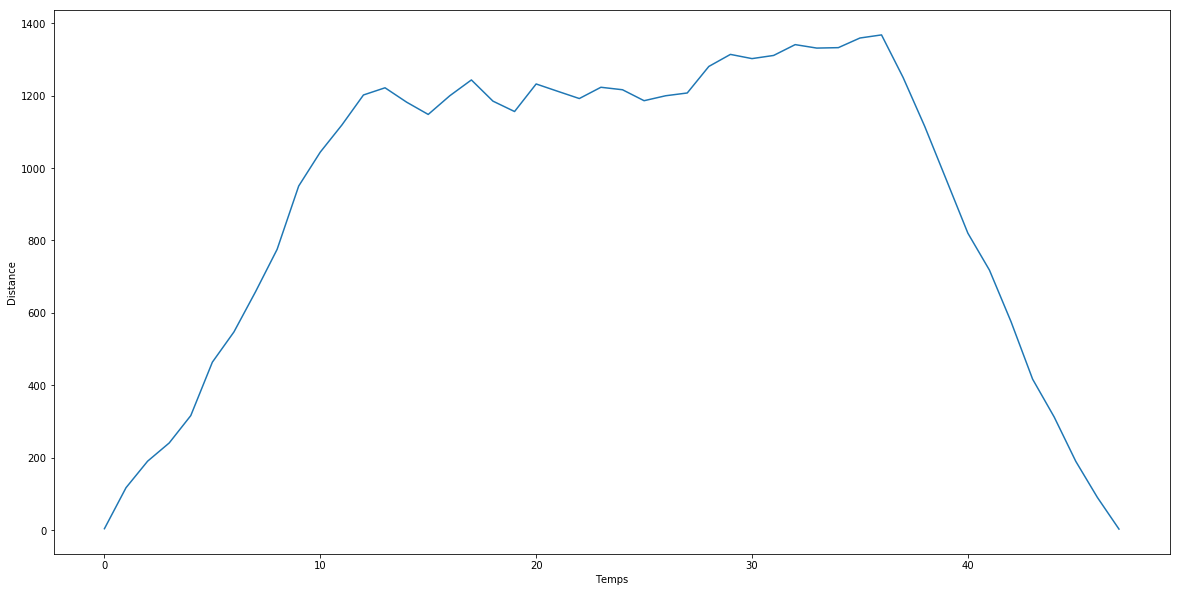

In [67]:
plt.figure(figsize = (20,10))
plt.plot(dist_array[758:806])
plt.ylabel('Distance')
plt.xlabel('Temps')
plt.show();

Graphiquement, le mouvement à lieu entre les indexs 758 et 806, l'erreur donnée par la fonction nombre_stop_avec_index est dû au choix d'epsilon, mais nous trouverons des indexs assez proches de la réalité tout de même.

In [66]:
print(' Début du mouvement 1:',str(df_78_2_mai['timestamp'].ix[758]), 
      '\n fin du mouvement 1:', str(df_78_2_mai['timestamp'].ix[806]))

 Début du mouvement 1: 2019-05-02 10:22:10 
 fin du mouvement 1: 2019-05-02 10:40:00


Les stops suivants sont:

'stop_2': [804, 1597], 'stop_3': [1653, 1758]

Donc le deuxième mouvement à lieu entre les indexs 1597 et 1653 environ.

Vérifions cela graphiquement.

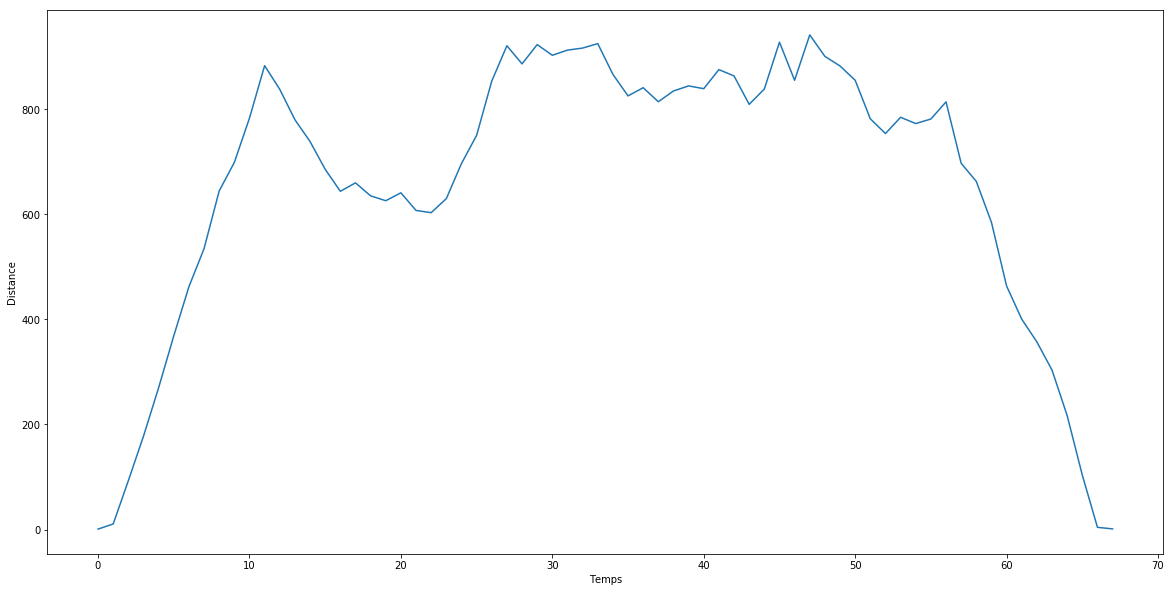

In [71]:
plt.figure(figsize = (20,10))
plt.plot(dist_array[1588:1656])
plt.ylabel('Distance')
plt.xlabel('Temps')
plt.show();

Graphiquement, le mouvement à lieu entre les indexs 1588 et 1656.

In [73]:
print(' Début du mouvement 2:',str(df_78_2_mai['timestamp'].ix[1588]), 
      '\n fin du mouvement 2:', str(df_78_2_mai['timestamp'].ix[1656]))

 Début du mouvement 2: 2019-05-02 21:23:50 
 fin du mouvement 2: 2019-05-02 21:47:40


Les stops suivants sont:
    
'stop_3': [1653, 1758],
'stop_4': [1781, 1817]

Donc le 3ème mouvement à lieu entre les indexs 1758 et 1781 environ.

Vérifions cela graphiquement.

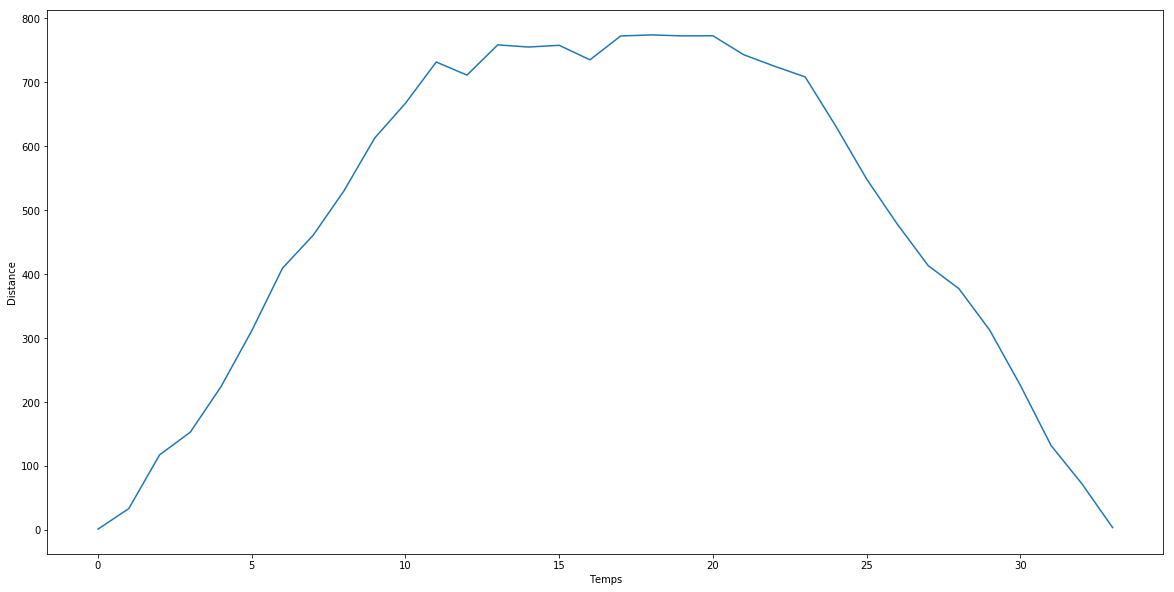

In [79]:
plt.figure(figsize = (20,10))
plt.plot(dist_array[1749:1783])
plt.ylabel('Distance')
plt.xlabel('Temps')
plt.show();

Graphiquement, le mouvement à lieu entre les indexs 1588 et 1656.

In [80]:
print(' Début du mouvement 3:',str(df_78_2_mai['timestamp'].ix[1749]), 
      '\n fin du mouvement 3:', str(df_78_2_mai['timestamp'].ix[1789]))

 Début du mouvement 3: 2019-05-02 23:16:00 
 fin du mouvement 3: 2019-05-02 23:33:40


Il nous reste à déterminer maintenant si les places de stationnement sont les mêmes ou non à partir des coordonnées GPS de chaque emplacements:

stop_1 de 00:01:50 à 10:30:40 environ à l'emplacement (48.869078952198706, 2.2974078229861803)

stop_2 de 10:37:20 à 21:32:30 environ à l'emplacement (48.864813087701904, 2.3554860212742796)

stop_3 de 21:44:00 à 23:23:00 environ à l'emplacement (48.86908272698171, 2.29742979469383)

stop_4 de 23:27:50 à 23:59:10 environ à l'emplacement (48.8553630653042, 2.30371957996463)

In [213]:
stop = {}

stop['stop_1'] = [48.869078952198706, 2.2974078229861803]
stop['stop_2'] = [48.864813087701904, 2.3554860212742796]
stop['stop_3'] = [48.86908272698171, 2.29742979469383]
stop['stop_4'] = [48.8553630653042, 2.30371957996463]

name = ['stop_1', 'stop_2', 'stop_3', 'stop_4']
n = len(name)

for iteration_1 in range(n - 1):
    
    for iteration_2 in range(iteration_1, n):
        
        stop_1 = name[iteration_1]
        lat_long_1 = [stop[stop_1][0], stop[stop_1][1]]
        #long_1 = stop[stop_1][1]

        if iteration_1 != iteration_2:
                      
            stop_2 = name[iteration_2]
            lat_long_2 = [stop[stop_2][0], stop[stop_2][1]]
            #long_2 = stop[stop_2][1]
            
            dist = distance(lat_long_1, lat_long_2)
        
            print('distance({}, {}) = {:.2f} mètres'.format(stop_1, stop_2, dist), '\n')

distance(stop_1, stop_2) = 4274.54 mètres 

distance(stop_1, stop_3) = 1.66 mètres 

distance(stop_1, stop_4) = 1593.50 mètres 

distance(stop_2, stop_3) = 4272.99 mètres 

distance(stop_2, stop_4) = 3930.06 mètres 

distance(stop_3, stop_4) = 1593.43 mètres 



Nous pouvons donc affirmer que la zone de stationnement 1 et 3 sont identiques, les autres non, il y a donc 3 emplacemenet de stationnement différents.

Note: bien sûr, s'il y avait plus de 4 zones de stationnement, j'aurai écrit un vrai script au lieu de le faire à la main.

### En résumé:

1. De minuit à 10h30 environ, le véhicule stationne sur un emplacement que l'on appelera stop_1

2. De 10h30 à 10h37 environ, le véhicule est en mouvement vers un emplacement stop_2

3. De 10h37 à 21h30 environ, le véhicule stationne en un emplacement stop_2 (différent de stop_1)

4. De 21h30 à 21h44, le véhicule est en mouvement et retourne à l'emplacement stop_1

5. De 21h44 à 23h25, le véhicule stationne sur l'emplacement stop_1

6. De 23h23 à 23h27 environ, le véhicule se déplace vers un nouvel emplacement différent des 2 précedents

7. Enfin, de 23h30 à la fin, le véhicule stationne sur un le nouvel emplacement (différent des 2 autres) et ne bougera plus.


# 2.       Quel est, à priori, le garage principal du véhicule n°57?

Nous définissions le "garage principal du vehicule" comme une zone de parking visitée plusieurs fois ou la durée de stationnement est assez longue

Nous créons un nouveau dataframe filtrant le véhicule 57 pendant toute la période, les lignes sont rangées dans l'ordre chronologique.

In [164]:
df_57 = merged_df[merged_df['id'] == 57]

df_57.sort_values(by = 'ts', inplace = True)
df_57.reset_index(inplace = True, drop = True)


De la même manière que précedement, nous calculons la distance parcourue entre deux plots GPS, c'est-à-dire entre deux lignes consécutives donc, dans l'ordre chronolique mais avec un pas de temps irregulier à cause du tracking espacé de 10 secondes lorsque le véhicule est en mouvent et environ 40 secondes lorsqu'il est à l'arrêt.

Nous prenons en compte un bruit dû à la précision du GPS et afin de lisser la courbe, nous prenons un pas de 10 lignes.

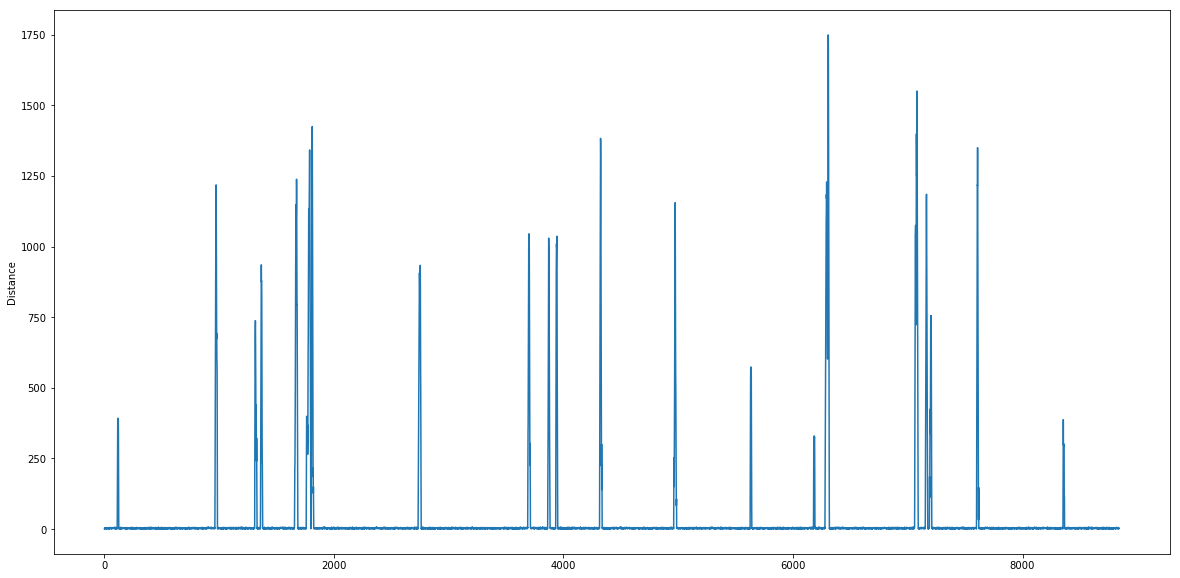

In [165]:
dist_array_57 = []

for row in range(df_57.shape[0] - 10):
    
    
        
    dist = distance([df_57['lat'][row+10], df_57['long'][row+10]], 
                    [df_57['lat'][row], df_57['long'][row]])
    dist_array_57.append(dist)

        
        
plt.figure(figsize = (20,10))
plt.plot(dist_array_57)
plt.ylabel('Distance')
plt.show();

Nous pouvons voir à l'oeil qu'il y a environ 21 arrêts plus ou moins long sur le graph.

Nous allons sortir les index correspondant suivant une distance entre 2 plots GPS infierieur à un epsilon à déterminer de sorte de se rapprocher des 21 arrêts sur le graph.

In [185]:
indexes_stop = nombre_stop_avec_index(df_57, epsilon = 10)

nombre d'arrets comptabilisés: 23 
 

stop_1 de 22:01:00 à 23:43:00 environ à l'emplacement (43.59711956388221, 1.4433495756785801)

stop_2 de 23:44:10 à 11:38:20 environ à l'emplacement (43.5936141705153, 1.44389997440633)

stop_3 de 11:42:00 à 16:12:50 environ à l'emplacement (43.605320643606504, 1.4376105786296698)

stop_4 de 16:14:50 à 16:50:00 environ à l'emplacement (43.60893873313089, 1.4413114656887702)

stop_5 de 16:51:40 à 20:53:40 environ à l'emplacement (43.611199374872704, 1.4309194338532099)

stop_6 de 20:58:10 à 22:00:10 environ à l'emplacement (43.597129213711604, 1.44339187802992)

stop_7 de 22:02:10 à 22:05:00 environ à l'emplacement (43.5947211254854, 1.4450428313606598)

stop_8 de 22:10:40 à 22:22:20 environ à l'emplacement (43.6111352482026, 1.42937758144946)

stop_9 de 22:28:40 à 11:05:10 environ à l'emplacement (43.5997740972805, 1.4269365835140602)

stop_10 de 11:09:50 à 23:46:40 environ à l'emplacement (43.5971108482078, 1.44337710934376)

stop_11 de 23:49:00 à

En choisissant espsilon = 8 mètres nous avons environ le même nombre d'arrets que trouvé visuelement.

Nous avons les index de début et fin de chaque stationnement:

In [186]:
indexes_stop

{'stop_1': [0, 120],
 'stop_10': [2759, 3697],
 'stop_11': [3711, 3871],
 'stop_12': [3882, 3941],
 'stop_13': [3949, 4323],
 'stop_14': [4336, 4969],
 'stop_15': [4985, 5635],
 'stop_16': [5640, 6187],
 'stop_17': [6190, 6287],
 'stop_18': [6316, 7068],
 'stop_19': [7090, 7161],
 'stop_2': [124, 971],
 'stop_20': [7173, 7197],
 'stop_21': [7208, 7607],
 'stop_22': [7618, 8361],
 'stop_23': [8365, 8849],
 'stop_3': [984, 1318],
 'stop_4': [1328, 1368],
 'stop_5': [1377, 1664],
 'stop_6': [1685, 1767],
 'stop_7': [1773, 1779],
 'stop_8': [1798, 1810],
 'stop_9': [1822, 2742]}

A présent, nous créons un data frame de statistique sur ces arrêts qui donne l'heure d'arrivée et de départ, la durée en heures et les coordonnées GPS

In [225]:
resume_parking = pd.DataFrame()

num_stop = 24 # + 1 à cause de l'indexation choisi

resume_parking['time_of_arrival'] = [np.nan] * num_stop
resume_parking['time_of_departure'] = [np.nan] * num_stop
resume_parking['duration'] = [np.nan] * num_stop
resume_parking['lat'] = [np.nan] * num_stop
resume_parking['lon'] = [np.nan] * num_stop


for parking in range(1,len(indexes_stop) + 1):
    
    index_arr = indexes_stop['stop_{}'.format(parking)][0]
    index_dep = indexes_stop['stop_{}'.format(parking)][1]
   
    
    resume_parking['time_of_arrival'][parking] = df_57['timestamp'][index_arr]
    resume_parking['time_of_departure'][parking] = df_57['timestamp'][index_dep]
    resume_parking['duration'][parking] = (df_57['ts'][index_dep] - df_57['ts'][index_arr]) / (60*60)

    index_stationnement_avg = index_arr + (index_dep - index_arr) / 2 


    resume_parking['lat'][parking] = df_57['lat'][int(index_stationnement_avg)]
    resume_parking['lon'][parking] = df_57['long'][int(index_stationnement_avg)]

resume_parking.dropna(inplace = True)

In [226]:
resume_parking.sort_values(by = 'duration', ascending = False, inplace = True)
resume_parking.reset_index(inplace = True, drop = True)

resume_parking

,time_of_arrival,time_of_departure,duration,lat,lon
0,2019-05-02 11:09:50,2019-05-02 23:46:40,12.613889,43.597111,1.443377
1,2019-05-01 22:28:40,2019-05-02 11:05:10,12.608333,43.599774,1.426937
2,2019-04-30 23:44:10,2019-05-01 11:38:20,11.902778,43.593614,1.443900
3,2019-05-04 11:07:00,2019-05-04 21:40:50,10.563889,43.612285,1.425223
4,2019-05-05 04:52:50,2019-05-05 15:04:40,10.197222,43.594740,1.445025
5,2019-05-03 16:53:10,2019-05-04 02:04:40,9.191667,43.597089,1.443326
6,2019-05-03 07:54:00,2019-05-03 16:49:50,8.930556,43.590477,1.436749
7,2019-05-04 02:06:10,2019-05-04 09:30:10,7.400000,43.592102,1.444642
8,2019-05-05 15:05:40,2019-05-05 21:57:30,6.863889,43.597106,1.443327
9,2019-05-04 23:27:50,2019-05-05 04:50:50,5.383333,43.603747,1.435952


Le dataframe ci-dessus nous donne les statistiques pour chaque arrets mais ne nous donne pas l'information si l'arret est identique à d'autre ou non.

Nous allons regarder cela dans la prochaine cellule.

In [220]:

def compute_distance_parking(resume_stationement):
    
    dist_parking = {}
    n = resume_stationement.shape[0]

    for index_i in range(n - 1):
        
        lat_long_1 = [resume_stationement['lat'][index_i], resume_stationement['lon'][index_i]]
        
        for index_j in range(index_i + 1, n):
            
            lat_long_2 = [resume_stationement['lat'][index_j], resume_stationement['lon'][index_j]]            
        
            dist_parking['{:03d}_{:03d}'.format(index_i, index_j)] = distance(lat_long_1, lat_long_2)
            
    return dist_parking



def group_parking(dist_parking, distance):
    
    
    res = {}
    
    for i in sorted(dist_parking.keys()):
        
        if dist_parking[i] < distance:
            
            first, last = i.split('_')
            first = int(first)
            last = int(last)
            
            if first in res:
                
                res[first].add(last)
                
            else:
                
                found = False
                
                for j in res.keys():
                    
                    if last in res[j]:
                        
                        found = True
                        res[j].add(first)
                        
                if not found:      
                    
                    res[first] = {first, last}
                    
    return res

la fonction group_parking donne la liste de tous les emplacements identiques à partir du dataframe resume_parking, si cette liste contient qu'un seul item, elle n'est pas comptabilisée.
Nous considérons, compte tenu de la précision GPS, que 2 parkings sont les mêmes s'ils sont placés à au moins 10 mètres l'un de l'autre.

In [260]:
dist_parking = compute_distance_parking(resume_parking)
group_parking(dist_parking, distance = 10)

{0: {0, 5, 8, 14, 16, 17}, 4: {4, 22}}

Nous avons donc que les emplacements 4 et 22 sont identiques ainsi que les emplacements 0, 5, 8, 14, 16 et 17.

Les autres emplacements ne sont visités qu'une fois et donc ne nous interesse pas d'après la définition d'un garage que nous avons donné.

Nous reprenons donc le dataframe précedent filtré sur ces emplacements pour faire plus de statistiques.

In [350]:
parking_1 = resume_parking.loc[[0, 5, 8, 14, 16, 17]]
parking_2 = resume_parking.loc[[4,22]]


print('parking_1 \n')
print("nombre de stationnements sur l'emplacement:", parking_1.shape[0])
print("temps moyen passé sur l'emplacement: {:.2f} heures".format(parking_1['duration'].mean()))
print("temps total passé sur l'emplacement {:.2f} heures:".format(parking_1['duration'].sum()), '\n \n')

print('parking_2 \n')
print("nombre de stationnements sur l'emplacement:", parking_2.shape[0])
print("temps moyen passé sur l'emplacement: {:.2f} heures".format(parking_2['duration'].mean()))
print("temps total passé sur l'emplacement: {:.2f} heures".format(parking_2['duration'].sum()), '\n \n \n')



parking_1 

nombre de stationnements sur l'emplacement: 6
temps moyen passé sur l'emplacement: 5.41 heures
temps total passé sur l'emplacement 32.46 heures: 
 

parking_2 

nombre de stationnements sur l'emplacement: 2
temps moyen passé sur l'emplacement: 5.12 heures
temps total passé sur l'emplacement: 10.24 heures 
 
 



D'après ce qui precède, compte tenu du nombre de fois ou le vehicule a stationné sur l'emplacement et son temps passé dessus, nous pouvons affirmer que le parking_1 est le garage du vehicule 57 situé à l'emplacement GPS (43.597111,	1.443377)

# 3. Si N véhicules (N>1) se déplacent ensemble sur une distance plus ou moins longue la même journée, ils forment un convoi. Identifiez les convois de la journée du 4 mai.


Pour cette question, nous considérons qu'un groupe de véhicules forment un convoi s'ils se déplacent ensemble sur une période de 5 minutes au moins.

Méthode utilisée:

1. Créer un dataframe (filtré sur le 4 mai) dont les lignes représentent les timestamps de manière unique où un déplacement est enregistré et les colonnes sont de la formes lat_i, long_i pour i dans l'ensembles des id des vehicules. Si le vehicule i est en mouvement au timestamp considéré lat_i et long_i sera affecté de sa latitude et longitude et s'il n'est pas en mouvement, lat_i et long_i sera affecté par un NaN.

2. Garder les timestamps de ce dataframe espacés de 5 minutes

3. Extraires la liste de vehicules en mouvement pour chaque timestamp

4. Créer un range de 5 minutes (utilisant la ligne i+1 et i) et détecter les vehicules toujours en mouvement sur ces ranges

5. Enfin, parmi chaque range, trouver chaque sous groupes de vehicules (s'il y en a plusieurs) en utilisant les distances les séparant, nous aurons les convois par range de 5 minutes 


##### Limitations:

1. Plus la flotte de véhicule est grande et plus la complexité de calcul de cette méthode sera grande puisque chaque vehicule est transposé en 2 colonnes

2. Si un vehicule A est en mouvement au timestamp t, qu'il s'arrete ensuite mais qu'il refait un mouvement au timestamp t + 5min, il sera considéré comme en mouvement durant tout le timerange de t à t+5min, pour y remédier, nous pouvons réduire l'intervalle de 5 minutes mais ceci augement la complexité de calcul.



In [130]:
# Filtration du dataframe sur le 4 mai uniquement

df_4_mai = merged_df[(merged_df['ts'] >= 1556928000)
                       & (merged_df['ts'] < 1557014400)]

df_4_mai.sort_values(by = 'ts', inplace = True)
df_4_mai.reset_index(inplace = True, drop = True)


In [139]:
# filtration des timestamps ou le vehicule considéré est en mouvement uniquement puis les dataframes sont concaténés


# epsilon est la distance minimum entre 2 ligne (donc 2 plot GPS) pour que le véhicule soit considéré en mouvement

def ts_where_vehicules_in_movement(data, epsilon):

    dico = {}

    for vehicule in data['id'].unique():

        res = []
        key = 'vehicule_{}'.format(vehicule)

        dico[key] = data[data['id'] == vehicule]
        dico[key].sort_values(by = 'ts', inplace = True)
        dico[key].reset_index(inplace = True, drop = True)

        for index in range(0, dico[key].shape[0] - 1):

            dist = distance([dico[key]['lat'][index + 1], 
                             dico[key]['long'][index + 1]], 
                            [dico[key]['lat'][index], 
                             dico[key]['long'][index]])

            #print(dist)

            if dist <= epsilon:
                 res.append(index)

        dico[key].drop(res, axis = 0, inplace = True)        

    df_merged = pd.concat(dico.values(), ignore_index=True)
    
    return df_merged

df_merged = ts_where_vehicules_in_movement(df_4_mai, epsilon = 3)

Nous créons le dataframe timestamps en lignes et lat_i, long_i en columns

In [10]:

def create_df_ts_in_function_gps(df_merged):

    time_range = df_merged['ts'].unique()

    df = pd.DataFrame()

    df['time_range'] = time_range

    for id_ in df_merged['id'].unique():

        df_id = df_merged[df_merged['id'] == id_]
        
        print(id_) # verbose

        lat_array = []
        long_array = []

        for ts in time_range:

                try:
                    lat = float(df_id['lat'][df_id['ts'] == ts])
                    long = float(df_id['long'][df_id['ts'] == ts])

                    lat_array.append(lat)
                    long_array.append(long)

                except: 

                    lat_array.append(np.nan)
                    long_array.append(np.nan)


        df['lat_{:04d}'.format(id_)] = lat_array
        df['long_{:04d}'.format(id_)] = long_array
        
        
    return df


df = create_df_ts_in_function_gps(df_merged)

66
10
70
25
21
78
80
20
12
56
1003
22
73
119
106
118
1023
11
77
13
109
1022
82
2
63
42
32
1009
23
39
114
86
111
14
35
45
85
17
64
53
1017
112
59
54
1
51
1007
79
113
0
1019
67
5
49
76
38
99
30
48
115
84
105
41
37
97
108
18
72
110
36
91
87
33
75
57
95
94
107
96
40
89
6
9
62
7
58
98
29
1016
88
117
60
55
27
24
4
50
1018
100
93
3
52
116
1014
1000
31
1024
44
43
19
81
8
28
26
103
16
102
65
104
1013
47
1004
1020
92
46
90
1008
74


In [11]:
df.shape

(8640, 257)

In [12]:
df.head()

,time_range,lat_0066,long_0066,lat_0010,long_0010,lat_0070,long_0070,lat_0025,long_0025,lat_0021,...,lat_0092,long_0092,lat_0046,long_0046,lat_0090,long_0090,lat_1008,long_1008,lat_0074,long_0074
0,1556928010,48.866968,2.358286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1556928040,48.866948,2.358230,NaN,NaN,NaN,NaN,NaN,NaN,48.865682,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1556928190,48.866989,2.358274,NaN,NaN,48.860521,2.298667,48.886318,2.312619,48.865685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1556928270,48.866944,2.358286,NaN,NaN,NaN,NaN,48.886319,2.312667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,48.836355,2.306689,NaN,NaN
4,1556928350,48.866952,2.358226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,48.870974,2.299527,NaN,NaN,NaN,NaN,NaN,NaN


A présent, nous considérons que le temps minimum de mouvement pour qu'un convoi soit considéré comme tel est de 5 minutes.

Ce time range est choisis complêtement arbitrairement.

Nous filtrons donc à nouveau le data frame crée et nous gardons les timestamps espacé d'au moins 5 minutes.

In [14]:
# Nous créons un array contenant les timestamps séparés de 5 min

def get_index_x_min_range(df, x = 5):

    min_ = df['time_range'].min()
    max_ = df['time_range'].max()

    range_x_min = []
    range_x_min.append(min_)

    i = min_.copy()

    while i <= max_:

        i = i + x*60

        if i > max_:

            break

        else:

            range_x_min.append(i)
            
    return range_x_min

range_5_min = get_index_x_min_range(df, x = 5)


In [15]:
# Création du nouveau data frame avec des timestamps toutes les 5 min

df_range_5_min = df.copy()
df_final_range_5_min = df_range_5_min[df_range_5_min['time_range'].isin(range_5_min)]
df_final_range_5_min.sort_values(by = 'time_range', inplace = True)
df_final_range_5_min.reset_index(drop = True, inplace = True)


#### Remarque importante: si le timestamp de la liste range_5_min n'existe pas dans le dataframe fourni, le time range entre les 2 lignes sera supérieur à 5 min

In [16]:
df_final_range_5_min.head()

,time_range,lat_0066,long_0066,lat_0010,long_0010,lat_0070,long_0070,lat_0025,long_0025,lat_0021,...,lat_0092,long_0092,lat_0046,long_0046,lat_0090,long_0090,lat_1008,long_1008,lat_0074,long_0074
0,1556928000,48.866981,2.35827,48.849827,2.295001,48.860544,2.298635,48.886349,2.312685,48.865701,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1556928300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.845647,2.325608,NaN,NaN,NaN,NaN,48.836347,2.306688,NaN,NaN
2,1556928600,48.866967,2.35828,NaN,NaN,NaN,NaN,NaN,NaN,48.865693,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1556928900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,48.845672,2.325625,NaN,NaN,NaN,NaN
4,1556929200,NaN,NaN,NaN,NaN,48.860532,2.298608,48.886330,2.312631,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.84025,2.336147


Création d'un dictionnaire contenant la liste de tous les vehicules en mouvement par timestamp et distant d'au moins 20 mètres.

#### ATTENTION:

Une étape de splitting est nécessaire. 
En effet, la fonction qui suit ne fait pas de séparation par rapport au groupe de vehicules extrait, ex:

pour un timestamp t, nous pouvons avoir la liste de véhicules [A, B, C, D] tels que les vehicules A et B sont distants de moins de 20 mètre, les véhicules C et D sont distants de moins de 20 mètres mais les groupes de véhicules [A, B] et [C, D] sont dans 2 villes différentes, c'est pourquoi une étape de split est ajouté par la suite.



In [19]:

def get_list_vehicules_per_ts(df_final_range_5_min, epsilon):

    list_vehicules_per_time_frame = {}

    for ts in df_final_range_5_min['time_range']:

        current_dico = {}

        df_cur = df_final_range_5_min[df_final_range_5_min['time_range'] == ts]

        df_not_nan = df_cur.dropna(axis = 'columns')


        list_vehicules = [x[-4:] for x in df_not_nan.columns]
        list_vehicules = np.unique(list_vehicules[1:-1])

        for index_1 in range(len(list_vehicules) - 1):

            T = []

            #print(list_vehicules[index_1])

            vehicule_1 = list_vehicules[index_1]

            #print(vehicule_1)

            lat_v_1 = df_not_nan['lat_{}'.format(vehicule_1)]
            long_v_1 = df_not_nan['long_{}'.format(vehicule_1)]

            for index_2 in range(index_1, len(list_vehicules)):

                if index_1 != index_2:

                    vehicule_2 = list_vehicules[index_2]

                    lat_v_2 = df_not_nan['lat_{}'.format(vehicule_2)]
                    long_v_2 = df_not_nan['long_{}'.format(vehicule_2)]

                    dist = distance([lat_v_1, long_v_1], [lat_v_2, long_v_2])

                    if dist < epsilon:

                        current_dico['{}_{}'.format(vehicule_1, vehicule_2)] = dist


        #print(current_dico)

        if len(current_dico) > 0:

            for key in current_dico.keys():

                #print(key)

                first, last = key.split('_')

                T.append(first)
                T.append(last)

        else:

            continue

        T_unique = np.unique(T)
        
        print(ts)
        print(T_unique)

        #df_final_range_5_min['convoy_vehicules'][df_final_range_5_min_test['time_range'] == ts] = str(T_unique)

        list_vehicules_per_time_frame[ts] = T_unique
    
    return list_vehicules_per_time_frame
    
    
list_vehicules_per_time_frame = get_list_vehicules_per_ts(df_final_range_5_min, epsilon = 20)

1556928300
['0013' '0050' '0092' '0098']
1556928600
['0042' '0048']
1556928900
['0007' '0031' '0053' '0090' '0105']
1556929200
['0019' '0031' '0050' '0099']
1556930100
['0019' '0099']
1556930700
['0007' '0055' '0082']
1556931900
['0006' '0019' '0029' '0032' '0040' '0042' '0048' '0053' '0082' '0092'
 '0099' '0105']
1556932200
['0032' '0040' '0065' '0089']
1556932500
['0040' '0090']
1556932800
['0019' '0031' '0032' '0075' '0082' '0090' '0099' '1008']
1556933100
['0000' '0016' '0018' '0035' '0050' '0058' '1003']
1556933400
['0000' '0032' '0055' '0065' '0089' '0090' '0092']
1556933700
['0000' '0007' '0050' '1014']
1556934000
['0000' '0018' '0035' '0040' '0080' '0082']
1556934300
['0007' '0031' '0040' '0050' '0055']
1556934600
['0007' '0013' '0021' '0075' '0080' '0098' '1008' '1014']
1556934900
['0016' '0021' '0022' '0055' '0088' '1003']
1556935200
['0000' '0021' '0022' '0032' '0088']
1556935500
['0000' '0032' '0055' '0082' '0090' '1014']
1556935800
['0016' '0050' '0058' '0065' '0082' '0089

1556976000
['0026' '0077' '0082' '0092' '0099' '1004']
1556976300
['0006' '0021' '0025' '0058' '0099' '0113']
1556976600
['0006' '0013' '0040' '0052' '0091' '1004']
1556976900
['0017' '0025' '0026' '0059' '0080' '0099']
1556977200
['0025' '0026' '0077' '0084' '0097']
1556977800
['0074' '0082' '0085' '0092']
1556978100
['0043' '0084' '0097' '0113' '1003']
1556978400
['0013' '0021' '0026' '0062' '0087' '0091' '0113']
1556978700
['0008' '0013' '0017' '0042' '0077' '0107' '0113' '0119']
1556979000
['0012' '0013' '0014' '0018' '0038' '0113' '1004']
1556979300
['0021' '0026' '0062' '0080' '0087' '0092' '0113' '0119']
1556980200
['0008' '0043' '0059' '0113' '0119']
1556980500
['0013' '0070' '0077' '0097' '0098' '0113' '0119']
1556980800
['0003' '0082' '0099']
1556981100
['0095' '0097' '0113' '1023']
1556981400
['0087' '0097' '0119']
1556981700
['0038' '0095']
1556982300
['0008' '0025' '0059' '0082' '0091' '0097' '0099']
1556982600
['0003' '0025' '0092']
1556982900
['0018' '0038' '0097' '0119'

In [20]:
list_vehicules_per_time_frame

{1556928300: array(['0013', '0050', '0092', '0098'], 
       dtype='<U4'), 1556928600: array(['0042', '0048'], 
       dtype='<U4'), 1556928900: array(['0007', '0031', '0053', '0090', '0105'], 
       dtype='<U4'), 1556929200: array(['0019', '0031', '0050', '0099'], 
       dtype='<U4'), 1556930100: array(['0019', '0099'], 
       dtype='<U4'), 1556930700: array(['0007', '0055', '0082'], 
       dtype='<U4'), 1556931900: array(['0006', '0019', '0029', '0032', '0040', '0042', '0048', '0053',
        '0082', '0092', '0099', '0105'], 
       dtype='<U4'), 1556932200: array(['0032', '0040', '0065', '0089'], 
       dtype='<U4'), 1556932500: array(['0040', '0090'], 
       dtype='<U4'), 1556932800: array(['0019', '0031', '0032', '0075', '0082', '0090', '0099', '1008'], 
       dtype='<U4'), 1556933100: array(['0000', '0016', '0018', '0035', '0050', '0058', '1003'], 
       dtype='<U4'), 1556933400: array(['0000', '0032', '0055', '0065', '0089', '0090', '0092'], 
       dtype='<U4'), 1556933

Maintenant, nous considérons uniquement les vehicules présents dans 2 timestamps consécutifs, c'est-à-dire que seuls les véhicules en mouvement pendant un time range de 5 minutes sont considérés.

La limitation 2. rentre en jeux ici:

###### Si un vehicule A est en mouvement au timestamp t, qu'il s'arrete ensuite mais qu'il refait un mouvement au timestamp t + 5min, il sera considéré comme en mouvement durant tout le timerange de t à t+5min, pour y remédier, nous pouvons réduire l'intervalle de 5 minutes mais ceci augement la complexité de calcul.


In [21]:
def get_vehicules_from_range(list_vehicules_per_time_frame):

    list_ts = np.sort(list(list_vehicules_per_time_frame.keys()))

    new_dico = {}

    for ts in range(len(list_ts) - 1):

        new_dico['range_{}_{}'.format(list_ts[ts], list_ts[ts+1])] = []

        list_1 = list_vehicules_per_time_frame[list_ts[ts]]
        list_2 = list_vehicules_per_time_frame[list_ts[ts+1]]

        list_final = np.concatenate([list_1,list_2])

        count_current = Counter(list_final)

        for vehicule in count_current.keys():

            if count_current[vehicule] > 1:



                new_dico['range_{}_{}'.format(list_ts[ts], 
                                              list_ts[ts+1]) ].append(vehicule)

    final_dico_range_vehicule = {}


    for key in new_dico.keys():

        length = len(new_dico[key])

        if length > 1:

            final_dico_range_vehicule[key] = new_dico[key]
            
    return final_dico_range_vehicule

    
    
final_dico_range_vehicule = get_vehicules_from_range(list_vehicules_per_time_frame)

In [22]:
final_dico_range_vehicule

{'range_1556929200_1556930100': ['0019', '0099'],
 'range_1556931900_1556932200': ['0032', '0040'],
 'range_1556934900_1556935200': ['0021', '0022', '0088'],
 'range_1556935200_1556935500': ['0000', '0032'],
 'range_1556935800_1556936100': ['0050', '0065', '0089'],
 'range_1556937300_1556937600': ['0021', '0040'],
 'range_1556938500_1556938800': ['0090', '0092', '0111'],
 'range_1556939400_1556939700': ['0062', '0099'],
 'range_1556939700_1556940000': ['0062', '0099', '0102'],
 'range_1556940000_1556940300': ['0000',
  '0007',
  '0021',
  '0025',
  '0026',
  '0031',
  '0032',
  '0040',
  '0041',
  '0049',
  '0050',
  '0054',
  '0055',
  '0062',
  '0080',
  '0082',
  '0090',
  '0092',
  '0099',
  '0102',
  '0111',
  '1000',
  '1014'],
 'range_1556940300_1556940600': ['0025',
  '0026',
  '0040',
  '0080',
  '0090',
  '0092'],
 'range_1556941200_1556941500': ['0040', '0062'],
 'range_1556941500_1556941800': ['0040', '0092', '0102'],
 'range_1556941800_1556942100': ['0000', '0099'],
 'rang

Nous avons donc la liste des ranges accompagnées de la liste des véhicules en mouvement et à moins de 20 mètres mais nous ne connaissons pas les sous groupes (s'il y en a), l'étape suivante permet de les trouver:

In [24]:
import networkx #######################################@

def get_convoy_per_time_range(final_dico_range_vehicule):

    convoy_completed_per_tr = {}

    for key in final_dico_range_vehicule.keys():

        print(key)


        if len(final_dico_range_vehicule[key]) <= 3:


            convoy_completed_per_tr[key] = final_dico_range_vehicule[key]


        else:


            ts = key[6:16]

            list_vehicules = list(final_dico_range_vehicule[key])

            n = len(list_vehicules)

            res = []

            for index_1 in range(n-1):



                vehicule_1 = list_vehicules[index_1]

                lat_1 = float(df_final_range_5_min['lat_{}'.format(vehicule_1)][df_final_range_5_min['time_range'] == int(ts)])
                long_1 = float(df_final_range_5_min['long_{}'.format(vehicule_1)][df_final_range_5_min['time_range'] == int(ts)])

                for index_2 in range(index_1, n):

                    vehicule_2 = list_vehicules[index_2]

                    if index_1 != index_2:

                        lat_2 = float(df_final_range_5_min['lat_{}'.format(vehicule_2)][df_final_range_5_min['time_range'] == int(ts)])
                        long_2 = float(df_final_range_5_min['long_{}'.format(vehicule_2)][df_final_range_5_min['time_range'] == int(ts)])            

                        dist = distance([lat_1, long_1], [lat_2, long_2])

                        if dist < 30:

                            #print(vehicule_1, vehicule_2)
                            #print(res)
                            res.append([vehicule_1, vehicule_2])

            #if key == 'range_1556959800_1556960100':        
            #print(key, '\n', res)

            g = networkx.Graph(res)
            final_set = []
            for subgraph in networkx.connected_component_subgraphs(g):
                final_set.append(subgraph.nodes())

            if len(final_set) == 1:
                final_set = np.concatenate(final_set)

            convoy_completed_per_tr[key] = final_set                           
                            
    return convoy_completed_per_tr

convoy_completed_per_tr = get_convoy_per_time_range(final_dico_range_vehicule)

range_1556929200_1556930100
range_1556931900_1556932200
range_1556934900_1556935200
range_1556935200_1556935500
range_1556935800_1556936100
range_1556937300_1556937600
range_1556938500_1556938800
range_1556939400_1556939700
range_1556939700_1556940000
range_1556940000_1556940300
range_1556940300_1556940600
range_1556941200_1556941500
range_1556941500_1556941800
range_1556941800_1556942100
range_1556942100_1556942400
range_1556942400_1556942700
range_1556943300_1556943600
range_1556944800_1556945400
range_1556946300_1556946600
range_1556946600_1556946900
range_1556948400_1556948700
range_1556949600_1556949900
range_1556952300_1556952600
range_1556952600_1556952900
range_1556954100_1556954400
range_1556955900_1556956200
range_1556956200_1556956500
range_1556956500_1556956800
range_1556956800_1556957100
range_1556957400_1556957700
range_1556957700_1556958000
range_1556958900_1556959200
range_1556959200_1556959500
range_1556959800_1556960100
range_1556962800_1556963100
range_1556963100_155

In [33]:
def print_convoy(convoy_completed_per_tr):

    fmt = "%H:%M"

    for range_time in convoy_completed_per_tr.keys():

        inf = range_time[6:16]
        sup = range_time[17:27]


        t_utc_inf = datetime.datetime.utcfromtimestamp(float(inf))
        t_utc_sup = datetime.datetime.utcfromtimestamp(float(sup))

        print('Convoi(s) avec vehicules entre {} et {}:'.format(t_utc_inf.strftime(fmt), t_utc_sup.strftime(fmt)), '\n')
        print(convoy_completed_per_tr[range_time], '\n \n')

print_convoy(convoy_completed_per_tr)

Convoi(s) avec vehicules entre 00:20 et 00:35: 

['0019', '0099'] 
 

Convoi(s) avec vehicules entre 01:05 et 01:10: 

['0032', '0040'] 
 

Convoi(s) avec vehicules entre 01:55 et 02:00: 

['0021', '0022', '0088'] 
 

Convoi(s) avec vehicules entre 02:00 et 02:05: 

['0000', '0032'] 
 

Convoi(s) avec vehicules entre 02:10 et 02:15: 

['0050', '0065', '0089'] 
 

Convoi(s) avec vehicules entre 02:35 et 02:40: 

['0021', '0040'] 
 

Convoi(s) avec vehicules entre 02:55 et 03:00: 

['0090', '0092', '0111'] 
 

Convoi(s) avec vehicules entre 03:10 et 03:15: 

['0062', '0099'] 
 

Convoi(s) avec vehicules entre 03:15 et 03:20: 

['0062', '0099', '0102'] 
 

Convoi(s) avec vehicules entre 03:20 et 03:25: 

['0080' '0082' '0054' '0041' '0031' '0049' '0090' '0055' '0007' '0092'
 '0025' '0050' '0000' '1014' '0062' '1000' '0032' '0026' '0021' '0040'
 '0102' '0099' '0111'] 
 

Convoi(s) avec vehicules entre 03:25 et 03:30: 

['0080' '0025' '0040' '0090' '0026' '0092'] 
 

Convoi(s) avec vehicule

### Essai avec un time range de 15 min et distance minimal de 20 mètres

In [29]:

def pipeline(x = 15, dist_min = 20):
    
    df_cust = ts_where_vehicules_in_movement(df_4_mai, epsilon = 3)
    
    df_cust = create_df_ts_in_function_gps(df_merged)
    
    range_x_min = get_index_x_min_range(df, x = x)
    
    df_range_x_min = df_cust.copy()
    df_range_x_min = df_range_x_min[df_range_x_min['time_range'].isin(range_x_min)]
    df_range_x_min.sort_values(by = 'time_range', inplace = True)
    df_range_x_min.reset_index(drop = True, inplace = True)
    
    list_vehicules_per_time_frame = get_list_vehicules_per_ts(df_range_x_min, epsilon = dist_min)
    
    final_dico_range_vehicule = get_vehicules_from_range(list_vehicules_per_time_frame)

    convoy_completed_per_tr = get_convoy_per_time_range(final_dico_range_vehicule)
    
    return(convoy_completed_per_tr)
    
    

In [30]:
convoy_completed_per_tr_15_min = pipeline(x = 15)

66
10
70
25
21
78
80
20
12
56
1003
22
73
119
106
118
1023
11
77
13
109
1022
82
2
63
42
32
1009
23
39
114
86
111
14
35
45
85
17
64
53
1017
112
59
54
1
51
1007
79
113
0
1019
67
5
49
76
38
99
30
48
115
84
105
41
37
97
108
18
72
110
36
91
87
33
75
57
95
94
107
96
40
89
6
9
62
7
58
98
29
1016
88
117
60
55
27
24
4
50
1018
100
93
3
52
116
1014
1000
31
1024
44
43
19
81
8
28
26
103
16
102
65
104
1013
47
1004
1020
92
46
90
1008
74
1556928900
['0007' '0031' '0053' '0090' '0105']
1556930700
['0007' '0055' '0082']
1556932500
['0040' '0090']
1556933400
['0000' '0032' '0055' '0065' '0089' '0090' '0092']
1556934300
['0007' '0031' '0040' '0050' '0055']
1556935200
['0000' '0021' '0022' '0032' '0088']
1556936100
['0007' '0021' '0050' '0055' '0065' '0089']
1556937000
['0000' '0007' '0031' '0041' '0055']
1556937900
['0025' '0040' '0080' '0099']
1556938800
['0021' '0026' '0050' '0054' '0082' '0090' '0092' '0099' '0111' '1000']
1556939700
['0062' '0099' '0102']
1556940600
['0025' '0026' '0040' '0080' '0090' 

In [35]:
print_convoy(convoy_completed_per_tr_15_min)

Convoi(s) avec vehicules entre 02:15 et 02:30: 

['0007', '0055'] 
 

Convoi(s) avec vehicules entre 03:30 et 03:45: 

['0040', '0092'] 
 

Convoi(s) avec vehicules entre 03:45 et 04:00: 

[['0014', '0067'], ['1014', '0032']] 
 

Convoi(s) avec vehicules entre 05:00 et 05:15: 

['0026', '0080'] 
 

Convoi(s) avec vehicules entre 06:00 et 06:15: 

['0040', '0090', '1000'] 
 

Convoi(s) avec vehicules entre 06:15 et 06:30: 

['0040', '1000'] 
 

Convoi(s) avec vehicules entre 07:45 et 08:00: 

['0012', '0014', '0099'] 
 

Convoi(s) avec vehicules entre 09:00 et 09:15: 

['0013', '0054'] 
 

Convoi(s) avec vehicules entre 10:15 et 10:30: 

['0058', '0087'] 
 

Convoi(s) avec vehicules entre 10:30 et 10:45: 

['0006', '1003'] 
 

Convoi(s) avec vehicules entre 13:30 et 14:00: 

['0013', '0091'] 
 

Convoi(s) avec vehicules entre 14:00 et 14:15: 

[['0026', '0062', '0021'], ['0087', '0113']] 
 

Convoi(s) avec vehicules entre 14:15 et 14:30: 

['0113', '0119'] 
 

Convoi(s) avec vehicules e

### Essai avec un time range de 5 min et distance minimale de 10 mètres

In [36]:
convoy_completed_per_tr_10m = pipeline(x = 5, dist_min = 10)

66
10
70
25
21
78
80
20
12
56
1003
22
73
119
106
118
1023
11
77
13
109
1022
82
2
63
42
32
1009
23
39
114
86
111
14
35
45
85
17
64
53
1017
112
59
54
1
51
1007
79
113
0
1019
67
5
49
76
38
99
30
48
115
84
105
41
37
97
108
18
72
110
36
91
87
33
75
57
95
94
107
96
40
89
6
9
62
7
58
98
29
1016
88
117
60
55
27
24
4
50
1018
100
93
3
52
116
1014
1000
31
1024
44
43
19
81
8
28
26
103
16
102
65
104
1013
47
1004
1020
92
46
90
1008
74
1556928300
['0013' '0050' '0092' '0098']
1556928600
['0042' '0048']
1556928900
['0007' '0031' '0053' '0090' '0105']
1556929200
['0019' '0031' '0050' '0099']
1556930100
['0019' '0099']
1556930700
['0007' '0055' '0082']
1556931900
['0006' '0019' '0029' '0032' '0040' '0042' '0048' '0053' '0082' '0092'
 '0099' '0105']
1556932200
['0032' '0040' '0065' '0089']
1556932500
['0040' '0090']
1556932800
['0019' '0031' '0032' '0075' '0082' '0090' '0099' '1008']
1556933100
['0000' '0016' '0018' '0035' '0050' '0058' '1003']
1556933400
['0000' '0032' '0055' '0065' '0089' '0090' '0092'

['0043' '0070' '0077' '0084' '1003']
1556974200
['0021' '0026' '0070' '0084' '0092' '0119' '1003']
1556974500
['0006' '0013' '0016' '0042' '0043' '0058' '0070' '0077' '0084' '0087'
 '0091' '0097' '0113' '0119' '1003' '1004']
1556974800
['0003' '0025']
1556975100
['0006' '0008' '0016' '0017']
1556975400
['0003' '0026' '0042' '0043' '0077' '0087' '0092' '0113']
1556975700
['0025' '0042' '0062' '0091']
1556976000
['0026' '0077' '0082' '0092' '0099' '1004']
1556976300
['0006' '0021' '0025' '0058' '0099' '0113']
1556976600
['0006' '0013' '0040' '0052' '0091' '1004']
1556976900
['0017' '0025' '0026' '0059' '0080' '0099']
1556977200
['0025' '0026' '0077' '0084' '0097']
1556977800
['0074' '0082' '0085' '0092']
1556978100
['0043' '0084' '0097' '0113' '1003']
1556978400
['0013' '0021' '0026' '0062' '0087' '0091' '0113']
1556978700
['0008' '0013' '0017' '0042' '0077' '0107' '0113' '0119']
1556979000
['0012' '0013' '0014' '0018' '0038' '0113' '1004']
1556979300
['0021' '0026' '0062' '0080' '0087' 

In [37]:
print_convoy(convoy_completed_per_tr_10m)

Convoi(s) avec vehicules entre 00:20 et 00:35: 

['0019', '0099'] 
 

Convoi(s) avec vehicules entre 01:05 et 01:10: 

['0032', '0040'] 
 

Convoi(s) avec vehicules entre 01:55 et 02:00: 

['0021', '0022', '0088'] 
 

Convoi(s) avec vehicules entre 02:00 et 02:05: 

['0000', '0032'] 
 

Convoi(s) avec vehicules entre 02:10 et 02:15: 

['0050', '0065', '0089'] 
 

Convoi(s) avec vehicules entre 02:35 et 02:40: 

['0021', '0040'] 
 

Convoi(s) avec vehicules entre 02:55 et 03:00: 

['0090', '0092', '0111'] 
 

Convoi(s) avec vehicules entre 03:10 et 03:15: 

['0062', '0099'] 
 

Convoi(s) avec vehicules entre 03:15 et 03:20: 

['0062', '0099', '0102'] 
 

Convoi(s) avec vehicules entre 03:20 et 03:25: 

['0080' '0082' '0054' '0041' '0031' '0049' '0090' '0055' '0007' '0092'
 '0025' '0050' '0000' '1014' '0062' '1000' '0032' '0026' '0021' '0040'
 '0102' '0099' '0111'] 
 

Convoi(s) avec vehicules entre 03:25 et 03:30: 

['0080' '0025' '0040' '0090' '0026' '0092'] 
 

Convoi(s) avec vehicule

# 4. Identifiez le couple de véhicules formant le plus souvent un convoi entre le 1er et le 5 mai.

On reprends en parti les fonctions de la question 3, certaines seront modifiées.

In [70]:
def get_convoy_per_time_range_couple(final_dico_range_vehicule):

    convoy_completed_per_tr = {}

    for key in final_dico_range_vehicule.keys():

        print(key)


        if len(final_dico_range_vehicule[key]) == 2:


            convoy_completed_per_tr[key] = final_dico_range_vehicule[key]


        else:


            ts = key[6:16]

            list_vehicules = list(final_dico_range_vehicule[key])

            n = len(list_vehicules)

            res = []

            for index_1 in range(n-1):



                vehicule_1 = list_vehicules[index_1]

                lat_1 = float(df_final_range_5_min['lat_{}'.format(vehicule_1)][df_final_range_5_min['time_range'] == int(ts)])
                long_1 = float(df_final_range_5_min['long_{}'.format(vehicule_1)][df_final_range_5_min['time_range'] == int(ts)])

                for index_2 in range(index_1, n):

                    vehicule_2 = list_vehicules[index_2]

                    if index_1 != index_2:

                        lat_2 = float(df_final_range_5_min['lat_{}'.format(vehicule_2)][df_final_range_5_min['time_range'] == int(ts)])
                        long_2 = float(df_final_range_5_min['long_{}'.format(vehicule_2)][df_final_range_5_min['time_range'] == int(ts)])            

                        dist = distance([lat_1, long_1], [lat_2, long_2])

                        if dist < 30:

                            #print(vehicule_1, vehicule_2)
                            #print(res)
                            res.append([vehicule_1, vehicule_2])

            #if key == 'range_1556959800_1556960100':        
            #print(key, '\n', res)

            g = networkx.Graph(res)
            final_set = []
            for subgraph in networkx.connected_component_subgraphs(g):
                final_set.append(subgraph.nodes())

            if len(final_set) == 1:
                final_set = np.concatenate(final_set)
                
            if len(final_set) == 2:

                convoy_completed_per_tr[key] = final_set                           
                            
    return convoy_completed_per_tr


def pipeline_couple(x = 15, dist_min = 20):
    
    df_cust = ts_where_vehicules_in_movement(df_merged, epsilon = 3)
    
    df_cust = create_df_ts_in_function_gps(df_merged)
    
    range_x_min = get_index_x_min_range(df, x = x)
    
    df_range_x_min = df_cust.copy()
    df_range_x_min = df_range_x_min[df_range_x_min['time_range'].isin(range_x_min)]
    df_range_x_min.sort_values(by = 'time_range', inplace = True)
    df_range_x_min.reset_index(drop = True, inplace = True)
    
    list_vehicules_per_time_frame = get_list_vehicules_per_ts(df_range_x_min, epsilon = dist_min)
    
    final_dico_range_vehicule = get_vehicules_from_range(list_vehicules_per_time_frame)

    convoy_completed_per_tr = get_convoy_per_time_range_couple(final_dico_range_vehicule)
    
    return(convoy_completed_per_tr)

In [45]:
convoy_completed_couple = pipeline(x = 15, dist_min = 20)

66
10
70
25
21
78
80
20
12
56
1003
22
73
119
106
118
1023
11
77
13
109
1022
82
2
63
42
32
1009
23
39
114
86
111
14
35
45
85
17
64
53
1017
112
59
54
1
51
1007
79
113
0
1019
67
5
49
76
38
99
30
48
115
84
105
41
37
97
108
18
72
110
36
91
87
33
75
57
95
94
107
96
40
89
6
9
62
7
58
98
29
1016
88
117
60
55
27
24
4
50
1018
100
93
3
52
116
1014
1000
31
1024
44
43
19
81
8
28
26
103
16
102
65
104
1013
47
1004
1020
92
46
90
1008
74
1556928900
['0007' '0031' '0053' '0090' '0105']
1556930700
['0007' '0055' '0082']
1556932500
['0040' '0090']
1556933400
['0000' '0032' '0055' '0065' '0089' '0090' '0092']
1556934300
['0007' '0031' '0040' '0050' '0055']
1556935200
['0000' '0021' '0022' '0032' '0088']
1556936100
['0007' '0021' '0050' '0055' '0065' '0089']
1556937000
['0000' '0007' '0031' '0041' '0055']
1556937900
['0025' '0040' '0080' '0099']
1556938800
['0021' '0026' '0050' '0054' '0082' '0090' '0092' '0099' '0111' '1000']
1556939700
['0062' '0099' '0102']
1556940600
['0025' '0026' '0040' '0080' '0090' 

In [46]:
print_convoy(convoy_completed_couple)

Convoi(s) avec vehicules entre 02:15 et 02:30: 

['0007', '0055'] 
 

Convoi(s) avec vehicules entre 03:30 et 03:45: 

['0040', '0092'] 
 

Convoi(s) avec vehicules entre 03:45 et 04:00: 

[['0014', '0067'], ['1014', '0032']] 
 

Convoi(s) avec vehicules entre 05:00 et 05:15: 

['0026', '0080'] 
 

Convoi(s) avec vehicules entre 06:15 et 06:30: 

['0040', '1000'] 
 

Convoi(s) avec vehicules entre 07:45 et 08:00: 

['0012' '0014'] 
 

Convoi(s) avec vehicules entre 09:00 et 09:15: 

['0013', '0054'] 
 

Convoi(s) avec vehicules entre 10:15 et 10:30: 

['0058', '0087'] 
 

Convoi(s) avec vehicules entre 10:30 et 10:45: 

['0006', '1003'] 
 

Convoi(s) avec vehicules entre 13:30 et 14:00: 

['0013', '0091'] 
 

Convoi(s) avec vehicules entre 14:00 et 14:15: 

[['0026', '0062', '0021'], ['0087', '0113']] 
 

Convoi(s) avec vehicules entre 14:15 et 14:30: 

['0113', '0119'] 
 

Convoi(s) avec vehicules entre 19:45 et 20:45: 

['0048', '0049'] 
 

Convoi(s) avec vehicules entre 22:00 et 22:

In [64]:
# filtration des timestamps ou le vehicule considéré est en mouvement uniquement puis les dataframes sont concaténés


# epsilon est la distance minimum entre 2 ligne (donc 2 plot GPS) pour que le véhicule soit considéré en mouvement

def ts_where_vehicules_in_movement(data, epsilon):

    dico = {}

    for vehicule in data['id'].unique():

        res = []
        key = 'vehicule_{}'.format(vehicule)

        dico[key] = data[data['id'] == vehicule]
        dico[key].sort_values(by = 'ts', inplace = True)
        dico[key].reset_index(inplace = True, drop = True)

        for index in range(0, dico[key].shape[0] - 1):

            dist = distance([dico[key]['lat'][index + 1], 
                             dico[key]['long'][index + 1]], 
                            [dico[key]['lat'][index], 
                             dico[key]['long'][index]])

            #print(dist)

            if dist <= epsilon:
                 res.append(index)

        dico[key].drop(res, axis = 0, inplace = True)        

    df_merged = pd.concat(dico.values(), ignore_index=True)
    
    return df_merged

df_merged_couple = ts_where_vehicules_in_movement(merged_df, epsilon = 3)

In [181]:
def create_df_ts_in_function_gps(df_merged):

    time_range = df_merged['ts'].unique()

    df = pd.DataFrame()

    df['time_range'] = time_range

    for id_ in df_merged['id'].unique():

        df_id = df_merged[df_merged['id'] == id_]
        
        print(id_) # verbose

        lat_array = []
        long_array = []

        for ts in time_range:

                try:
                    lat = float(df_id['lat'][df_id['ts'] == ts])
                    long = float(df_id['long'][df_id['ts'] == ts])

                    lat_array.append(lat)
                    long_array.append(long)

                except: 

                    lat_array.append(np.nan)
                    long_array.append(np.nan)


        df['lat_{:04d}'.format(id_)] = lat_array
        df['long_{:04d}'.format(id_)] = long_array
        
        
    return df


df_couple = create_df_ts_in_function_gps(df_merged_couple)

66
37
50
85
74
29
94
64
31
62
7
2
91
67
44
24
28
1022
72
49
76
77
1017
38
65
87
102
99
56
54
20
48
47
1013
1020
1000
90
4
3
10
81
118
23
93
84
1019
46
73
114
40
39
111
95
117
11
14
32
98
116
19
105
80
33
51
86
21
100
60
43
27
113
1007
112
26
53
13
109
75
42
79
1008
58
41
89
9
1023
97
1003
18
92
119
25
1024
70
78
16
55
6
1014
1004
36
96
106
108
35
82
0
103
104
12
52
1009
88
1016
57
115
107
45
1
30
22
59
8
5
110
1018
63
17


In [182]:
df_couple.to_csv('df_couple_2.csv')

In [185]:
(df_couple['time_range'].max() - df_couple['time_range'].min())/60/60

119.99722222222222

In [186]:
def get_index_x_min_range(df, x = 5):

    min_ = df['time_range'].min()
    max_ = df['time_range'].max()

    range_x_min = []
    range_x_min.append(min_)

    i = min_.copy()

    while i <= max_:

        i = i + x*60

        if i > max_:

            break

        else:

            range_x_min.append(i)
            
    return range_x_min

range_5_min_couple = get_index_x_min_range(df_couple, x = 5)

In [187]:
df_range_5_min_couple = df_couple.copy()
df_final_range_5_min_couple = df_range_5_min_couple[df_range_5_min_couple['time_range'].isin(range_5_min_couple)]
df_final_range_5_min_couple.sort_values(by = 'time_range', inplace = True)
df_final_range_5_min_couple.reset_index(drop = True, inplace = True)


In [ ]:
# check timestamp


def get_list_vehicules_per_ts(df_final_range_5_min_couple, epsilon):

    list_vehicules_per_time_frame = {}

    for ts in df_final_range_5_min_couple['time_range']:
        
        #print(ts, len(df_final_range_5_min_couple['time_range']))

        current_dico = {}

        df_cur = df_final_range_5_min_couple[df_final_range_5_min_couple['time_range'] == ts]

        df_not_nan = df_cur.dropna(axis = 'columns')


        list_vehicules = [x[-4:] for x in df_not_nan.columns]
        list_vehicules = np.unique(list_vehicules[1:-1])
        

        for index_1 in range(len(list_vehicules) - 1):

            T = []

            #print(list_vehicules[index_1])

            vehicule_1 = list_vehicules[index_1]

            #print(vehicule_1)

            lat_v_1 = df_not_nan['lat_{}'.format(vehicule_1)]
            long_v_1 = df_not_nan['long_{}'.format(vehicule_1)]

            for index_2 in range(index_1, len(list_vehicules)):

                if index_1 != index_2:

                    vehicule_2 = list_vehicules[index_2]

                    lat_v_2 = df_not_nan['lat_{}'.format(vehicule_2)]
                    long_v_2 = df_not_nan['long_{}'.format(vehicule_2)]

                    dist = distance([lat_v_1, long_v_1], [lat_v_2, long_v_2])

                    if dist < epsilon:

                        current_dico['{}_{}'.format(vehicule_1, vehicule_2)] = dist


        #print(current_dico)

        if len(current_dico) > 0:

            for key in current_dico.keys():

                #print(key)

                first, last = key.split('_')

                T.append(first)
                T.append(last)

        else:

            continue

        T_unique = np.unique(T)
        
        print(ts)
        print(T_unique)

        #df_final_range_5_min['convoy_vehicules'][df_final_range_5_min_test['time_range'] == ts] = str(T_unique)

        list_vehicules_per_time_frame[ts] = T_unique
    
    return list_vehicules_per_time_frame
    
    

list_vehicules_per_time_frame_couple = get_list_vehicules_per_ts(df_couple, epsilon = 20)

1556663980
['0022' '0088']
1556664950
['0113' '1003']
1556665170
['0019' '0064' '0099' '0113']
1556666100
['0075' '0103']
1556666200
['0031' '0111' '0113']
1556666330
['0031' '0113']
1556666550
['0043' '0105']
1556667210
['0016' '0031' '0054' '0084']
1556667240
['0044' '0084' '0105']
1556667410
['0077' '0105' '1024']
1556667840
['0031' '0054']
1556667850
['0064' '0108' '1003']
1556667870
['0043' '0084' '1003']
1556667880
['0043' '0064' '1003']
1556667920
['0036' '0108']
1556667930
['0016' '0044' '0105']
1556667950
['0031' '0043' '0064' '0073' '0105' '0106']
1556667970
['0016' '0104']
1556667980
['0064' '0108']
1556668030
['0002' '0036' '0044']
1556668240
['0002' '0044' '0105']
1556668520
['0002' '0016' '0031' '0036' '0043' '0044' '0054' '0064' '0077' '0084'
 '0103' '0104' '0105' '0108' '0111' '0113' '0119' '1003' '1024']
1556668670
['0002' '0016' '0031' '0036' '0043' '0044' '0054' '0064' '0077' '0084'
 '0103' '0104' '0105' '0108' '0111' '0113' '0119' '1003' '1024']
1556668870
['0002' '

1556721190
['0085' '1014']
1556721320
['0000' '0067' '1004']
1556721790
['0067' '0080' '1014']
1556721870
['0067' '0085']
1556721940
['0057' '1016']
1556723040
['0067' '0080' '0102' '1004']
1556723090
['0036' '0092']
1556723130
['0036' '0092']
1556723880
['0000' '0080']
1556723910
['0084' '0114']
1556723940
['0080' '0085']
1556724140
['0067' '1014']
1556724500
['0003' '0040']
1556725090
['0000' '1014']
1556725400
['0000' '1004' '1014']
1556725480
['0067' '1014']
1556725590
['0000' '0085']
1556725640
['0000' '0102']
1556725970
['0003' '0040']
1556726090
['0000' '0085']
1556726140
['0025' '0085']
1556726270
['0003' '0040' '0043' '0096']
1556726700
['0017' '0022']
1556726760
['0000' '0032']
1556726980
['0078' '0087']
1556727370
['0070' '0098' '0105' '1014']
1556727500
['0022' '0070' '1014' '1016']
1556727680
['0043' '0070' '0080' '0096']
1556727800
['0017' '0022']
1556728090
['0002' '0037']
1556728200
['0007' '0067' '0085' '0102']
1556728430
['0006' '0017' '0029' '1016']
1556728820
['0067

1556782520
['0017' '0063']
1556782590
['0007' '1014']
1556782980
['0018' '0113']
1556783120
['0013' '0056' '0091' '0099']
1556783290
['0016' '0018' '0029' '0077']
1556783480
['0113' '1004' '1007']
1556783510
['0048' '0114']
1556783590
['0003' '0113']
1556783690
['0080' '0100']
1556784240
['0016' '1007']
1556784380
['0016' '1007']
1556784600
['0007' '0065' '0102' '1007']
1556784690
['0065' '0113']
1556785230
['0016' '0018' '0031']
1556785640
['0003' '1007']
1556785680
['0016' '1007']
1556786160
['0003' '0016' '0084']
1556786330
['0065' '0113']
1556786600
['0007' '0102']
1556786660
['0003' '0065' '0113']
1556786820
['0029' '0065' '0077' '0084']
1556786890
['0031' '0065']
1556787040
['0065' '0084']
1556787330
['0013' '0056']
1556787480
['0016' '0018' '0065']
1556787690
['0028' '0074']
1556787710
['0003' '0057' '0088' '1004' '1007']
1556787730
['0065' '0091']
1556787770
['0016' '0018']
1556788310
['0091' '1004']
1556788480
['0016' '0065' '0113']
1556788580
['0057' '0088']
1556788680
['0029

1556813000
['0065' '0097' '0102' '0108' '1004']
1556813080
['0002' '0007']
1556813180
['0000' '0007' '0087' '0111']
1556813220
['0019' '0077']
1556813480
['0019' '0087']
1556813710
['0087' '0111' '1007']
1556813770
['0077' '0097' '1004']
1556814030
['0003' '1004']
1556814430
['0002' '0031' '0108' '1004']
1556814480
['0103' '0108' '1014']
1556814670
['0007' '0019' '0054' '1000']
1556814680
['1014' '1024']
1556814770
['0000' '0102' '0111' '1000']
1556815020
['0102' '1024']
1556815300
['0103' '0117']
1556815470
['0002' '0007']
1556815600
['0054' '0096']
1556815740
['0000' '0002' '0103']
1556815830
['0007' '0096']
1556816010
['0000' '0025']
1556816050
['0018' '0038' '0043' '0087']
1556816080
['0002' '0096' '0117']
1556816180
['0087' '0097']
1556816610
['0043' '0111']
1556817040
['0074' '1024']
1556817210
['0019' '0043']
1556817530
['0117' '1024']
1556817590
['0002' '0054']
1556817670
['0025' '0117']
1556817780
['0002' '0108' '1024']
1556817790
['0111' '1007']
1556817800
['0002' '0025']
155

1556844980
['0026' '0041' '0048' '0065' '0082' '0113']
1556845070
['0036' '0048' '0065' '0074']
1556845100
['0077' '0119']
1556845150
['0026' '0055']
1556845200
['0048' '0051' '0055' '0082' '0113' '0119' '1003']
1556845250
['0049' '0055' '0097']
1556845350
['0091' '0113' '1003']
1556845490
['0016' '0097' '1024']
1556845720
['0026' '0055']
1556845770
['0082' '1014']
1556845920
['0004' '0016' '0082' '0091' '1014']
1556846170
['0004' '0041']
1556846310
['0042' '0117']
1556846340
['0022' '0048' '0077' '0088' '0097' '0119']
1556846390
['0113' '0119']
1556846490
['0026' '0049' '0113' '1000']
1556847080
['0041' '0050']
1556847610
['0016' '0035']
1556847720
['0055' '0087' '0091' '0113' '1003']
1556847870
['0025' '1019']
1556848210
['0006' '0016' '0026' '0029' '0048' '0077' '0091' '0114']
1556848660
['0004' '0012' '0018' '0038' '0042' '0047' '0054' '0074' '0077' '0097'
 '0117' '1003']
1556848680
['0022' '0049' '0087' '0088']
1556848750
['0026' '0097' '1000']
1556848780
['0041' '0050' '0082']
15

1556873890
['0000' '0047' '1003' '1007']
1556874010
['0003' '0084' '1004' '1014']
1556874090
['0003' '0036' '0084' '0092']
1556874390
['0114' '1007']
1556874680
['0041' '0047' '0074' '1003']
1556874770
['0097' '1003']
1556874870
['0000' '0076']
1556874920
['0114' '1024']
1556875280
['0016' '0049' '0114']
1556875290
['1003' '1007']
1556875330
['0004' '0050' '1004']
1556875580
['0036' '0092' '0114' '1003']
1556875620
['0004' '0026' '0095' '0097']
1556875720
['0055' '0111']
1556875820
['0016' '0074']
1556875850
['1003' '1024']
1556876040
['0041' '0047']
1556876420
['0041' '0076']
1556876450
['0004' '0047' '0050' '0095']
1556876830
['0041' '0076']
1556876930
['0003' '0019' '0084' '0099']
1556876950
['0000' '0004']
1556876970
['0000' '0047' '1004']
1556876990
['0041' '1004']
1556877010
['0038' '0112']
1556877020
['0095' '1014']
1556877030
['0000' '0025' '0076']
1556877040
['0041' '1004']
1556877050
['0010' '0031']
1556877070
['0016' '0097']
1556877100
['0019' '0066' '0114' '1003' '1007']
15

1556939390
['0007' '0025' '0049' '0090']
1556939740
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '1014']
1556939820
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '1014']
1556939830
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '1014']
1556939870
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '1014']
1556939930
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '1014']
1556940020
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '004

1556967970
['0022' '0045' '0110']
1556968100
['0016' '0070' '0077' '0091']
1556968250
['0003' '0054' '0059' '0107']
1556968640
['0017' '0107']
1556968650
['0003' '0016' '0021' '0040' '0042' '0087']
1556968810
['0012' '0014']
1556968850
['0087' '0091' '1003']
1556968870
['0013' '0077' '0091']
1556968980
['0025' '0041' '0080']
1556969010
['0018' '0021' '0026' '0040' '0092' '0113']
1556969230
['0058' '0070']
1556969310
['0026' '0040' '0041' '0054']
1556969780
['0025' '0054' '0062']
1556969850
['0021' '0092' '0099']
1556969990
['0058' '0091']
1556970530
['0006' '0058']
1556970740
['0025' '0092']
1556970890
['0042' '0091']
1556970920
['0042' '0043' '0058']
1556971190
['0006' '0013' '0043' '1004']
1556971300
['0021' '0080' '0082']
1556971500
['0040' '0080' '0099']
1556971670
['0097' '1003']
1556971680
['0013' '0016' '0043' '0070']
1556971740
['0013' '0077']
1556971780
['0003' '0021' '0087' '0097']
1556971860
['0062' '0082']
1556972020
['0013' '0077']
1556972030
['0077' '0091']
1556972050
['0

1557035900
['0016' '1000']
1557036660
['0052' '0060' '0097']
1557036690
['0020' '0025' '0038' '0049']
1557036820
['0000' '0025']
1557036850
['0097' '0113']
1557036880
['0017' '0059']
1557037290
['0018' '0038']
1557037610
['0032' '0102']
1557037790
['1000' '1003']
1557038120
['0102' '0118']
1557038200
['0000' '0077']
1557038650
['0060' '1023']
1557038710
['0076' '1013']
1557038850
['0049' '0050' '0118']
1557038880
['0019' '0067' '0097']
1557038980
['0049' '0077' '0102']
1557039020
['0000' '0032']
1557039130
['0042' '0048']
1557039480
['0000' '0032' '0060' '1000' '1003']
1557039590
['0052' '0113']
1557039780
['0052' '0058' '0084' '0086' '0113']
1557039830
['0032' '0039' '0082' '0105']
1557039960
['0049' '0118']
1557039970
['0067' '1003']
1557040160
['0019' '0025' '0050' '1003']
1557040190
['0032' '0077']
1557040280
['0025' '0082']
1557040360
['0084' '0097']
1557040500
['0011' '0054']
1557040770
['0049' '0102']
1557040790
['0049' '0077' '0102' '0118']
1557040880
['0052' '0060' '1003']
155

1557065620
['0019' '0087' '0119']
1557065680
['0009' '0026' '0031' '1024']
1557065820
['0040' '0050']
1557066120
['0016' '0043' '0060']
1557066130
['0000' '0002' '0040']
1557066290
['0009' '0026']
1557066350
['0025' '0102']
1557066360
['0025' '0032' '0040']
1557066420
['0031' '0067' '0070' '0077' '0087' '1024']
1557066670
['0016' '1024']
1557066750
['0016' '0087']
1557066920
['0011' '0038' '0094' '1014']
1557066930
['0019' '0113']
1557067300
['0049' '0099']
1557067360
['0032' '0055' '0118' '1007']
1557067480
['0077' '0099']
1557067520
['0014' '0038' '0055' '0081' '0094' '0118' '1004' '1007']
1557067740
['0032' '0077' '0102']
1557067770
['0019' '0052']
1557068000
['0031' '0087' '0113']
1557068070
['0067' '0119']
1557068300
['0040' '0043' '0082' '0087' '0111' '1004']
1557068330
['0049' '0118']
1557068570
['0043' '0049' '0070' '0111' '0119' '1004']
1557068770
['0031' '1024']
1557068960
['0002' '0043' '0102' '0119']
1557069150
['0085' '0089']
1557069330
['0019' '0031' '0043' '0052']
155706

1556669130
['0002' '0016' '0031' '0036' '0043' '0044' '0054' '0064' '0077' '0084'
 '0103' '0104' '0105' '0108' '0111' '0113' '0119' '1003' '1024']
1556669240
['0002' '0016' '0031' '0036' '0043' '0044' '0054' '0064' '0077' '0084'
 '0103' '0104' '0105' '0108' '0111' '0113' '0119' '1003' '1024']
1556669280
['0002' '0016' '0031' '0036' '0043' '0044' '0054' '0064' '0077' '0084'
 '0103' '0104' '0105' '0108' '0111' '0113' '0119' '1003' '1024']
1556669960
['0108' '1003']
1556670190
['0002' '1003']
1556670250
['0002' '0104' '0119']
1556670460
['0002' '0104']
1556670850
['0105' '0113']
1556671050
['0016' '0036' '0044' '0077' '0108']
1556671100
['0113' '1003']
1556671230
['0113' '1024']
1556671250
['0036' '1024']
1556671280
['0002' '0036' '0057' '0078' '0087' '0105' '1016' '1024']
1556671390
['0077' '0105']
1556671430
['0036' '0104']
1556672300
['0064' '0108']
1556672510
['0043' '0104' '0108' '0119']
1556672610
['0016' '0044' '0078' '0087']
1556672740
['0113' '1024']
1556672910
['0054' '0119']
15

1556724060
['0017' '0022' '1016']
1556724300
['0000' '1014']
1556724610
['0000' '0032']
1556724870
['0006' '0029']
1556724980
['0098' '0105']
1556725190
['0017' '1016']
1556725210
['0000' '0067']
1556725300
['0016' '0044' '0057' '1016']
1556725450
['0102' '1004']
1556725890
['0085' '1004']
1556726220
['0017' '0057']
1556726250
['0032' '0067' '0070']
1556726260
['0070' '0102']
1556726310
['0043' '0096']
1556726720
['0003' '0095']
1556726890
['0025' '0080']
1556727000
['0006' '0029']
1556727240
['0025' '0032']
1556727290
['0078' '0087']
1556727320
['0002' '0037']
1556727340
['0067' '0080' '0085']
1556727570
['0067' '0080' '0085']
1556727690
['0098' '0105']
1556728150
['0078' '0087']
1556728290
['0025' '0080' '0085']
1556728460
['0000' '0067' '0085']
1556728570
['0070' '0085' '1004']
1556728660
['0067' '0102']
1556728960
['0098' '0105' '1003' '1007']
1556729190
['0007' '0085']
1556729750
['0000' '0085']
1556730490
['0000' '0002' '0037' '0080']
1556730540
['1004' '1014']
1556730610
['0000'

1556743440
['0000' '0006' '0007' '0018' '0025' '0031' '0032' '0037' '0067' '0070'
 '0080' '0085' '0097' '0099' '0102' '0118' '1004' '1013' '1014' '1022']
1556743450
['0000' '0006' '0007' '0025' '0032' '0037' '0067' '0070' '0080' '0085'
 '0097' '0099' '0102' '0118' '1004' '1013' '1014' '1022']
1556743460
['0000' '0006' '0007' '0025' '0032' '0037' '0040' '0067' '0070' '0080'
 '0085' '0095' '0097' '0099' '0102' '0118' '1004' '1013' '1014' '1022']
1556743470
['0000' '0006' '0007' '0025' '0032' '0037' '0067' '0070' '0080' '0085'
 '0097' '0099' '0102' '0118' '1004' '1013' '1014' '1022']
1556743480
['0000' '0006' '0007' '0025' '0032' '0037' '0067' '0070' '0080' '0085'
 '0097' '0099' '0102' '0118' '1004' '1013' '1014' '1022']
1556743560
['0007' '0037' '0085' '0097' '0102']
1556744150
['0006' '0037']
1556744540
['0018' '0037' '0038' '0085' '1004']
1556744880
['0037' '0085']
1556744920
['0037' '0097']
1556745320
['0007' '0037']
1556745910
['0022' '0037' '0088' '0097']
1556746050
['0007' '0025' '

['0043' '1022']
1556799970
['0046' '0096' '0102' '1019']
1556800250
['0113' '1000' '1004']
1556800330
['0002' '0025']
1556801180
['0003' '0028' '0074' '0077' '1000']
1556801210
['0043' '0077' '0113' '0114' '1000']
1556801220
['0023' '0037']
1556801410
['0018' '0031' '0046' '0077' '0099' '0111' '1017' '1019']
1556801560
['0031' '0091' '1000']
1556801580
['0002' '0003' '0031' '0096' '1000']
1556801680
['0016' '0018']
1556801830
['0003' '0084' '0091' '0114' '1022']
1556801890
['0018' '0091' '1007']
1556801950
['0007' '0016' '0102' '1004' '1024']
1556801990
['0031' '0114' '1014' '1024']
1556802080
['0091' '0111' '1000']
1556802330
['0016' '1004' '1007']
1556802480
['0018' '0031']
1556802720
['0020' '0051']
1556802770
['0025' '0065' '1000' '1024']
1556802790
['0023' '0037' '0114' '1003' '1007']
1556802830
['0016' '0023' '0031' '0037' '1007' '1022']
1556803140
['0031' '0065']
1556803310
['0084' '0114']
1556803320
['0007' '0016' '0031' '0040' '0081' '1014']
1556803330
['0018' '0113']
15568033

1556837320
['0035' '1024']
1556837340
['0012' '0070' '0097' '1007']
1556837400
['0042' '0048']
1556837530
['0019' '0035' '0055' '0099' '0111']
1556837710
['0042' '0048']
1556838610
['0022' '0088']
1556838750
['0055' '0119']
1556838790
['0055' '1007' '1024']
1556838870
['0031' '0054']
1556838980
['0012' '0026' '0035' '0070']
1556838990
['0026' '0119' '1024']
1556839460
['0026' '0077' '0111']
1556839900
['0035' '0049']
1556839920
['0012' '0049']
1556840110
['0006' '0029']
1556840490
['0016' '0077' '0111']
1556841330
['0022' '0048' '0049' '0088']
1556841470
['0074' '0077']
1556841640
['0012' '0070' '1007']
1556841660
['0012' '0016' '0091']
1556841720
['0026' '0070' '0074' '1024']
1556841970
['0012' '0016' '0026' '0035' '0048' '0049' '0055' '0065' '0070' '0074'
 '0077' '0087' '0091' '0097' '0111' '0113' '0114' '0119' '1000' '1003'
 '1007' '1024']
1556842010
['0012' '0016' '0026' '0035' '0048' '0049' '0055' '0065' '0070' '0074'
 '0077' '0087' '0091' '0097' '0111' '0113' '0114' '0119' '1000'

1556852440
['0000' '0004' '0007' '0025' '0032' '0037' '0041' '0043' '0047' '0050'
 '0051' '0054' '0076' '0082' '0095' '0099' '0102' '1004' '1014']
1556852450
['0000' '0004' '0007' '0025' '0032' '0037' '0041' '0043' '0047' '0050'
 '0051' '0054' '0076' '0082' '0095' '0097' '0099' '0102' '1003' '1004'
 '1007' '1014']
1556852460
['0000' '0004' '0007' '0012' '0025' '0032' '0037' '0041' '0043' '0047'
 '0050' '0051' '0054' '0076' '0082' '0095' '0099' '0102' '1004' '1007'
 '1014']
1556852470
['0000' '0004' '0007' '0012' '0025' '0032' '0037' '0041' '0043' '0047'
 '0050' '0051' '0054' '0076' '0082' '0095' '0099' '0102' '1004' '1014'
 '1024']
1556852480
['0000' '0004' '0007' '0025' '0032' '0037' '0041' '0043' '0047' '0050'
 '0051' '0054' '0076' '0082' '0095' '0099' '0102' '1004' '1014']
1556852490
['0000' '0004' '0007' '0025' '0032' '0037' '0041' '0043' '0045' '0047'
 '0048' '0050' '0051' '0054' '0057' '0076' '0082' '0095' '0099' '0102'
 '0114' '1004' '1014']
1556852500
['0000' '0004' '0007' '001

1556861090
['0036' '0037' '0055' '0091' '0092' '0097' '0099' '0111']
1556861120
['0026' '0035' '0037' '0041' '0099']
1556861160
['0007' '0026' '0035' '0037' '0050' '0097' '0099' '1007']
1556861290
['0032' '0037' '0114' '1007']
1556861310
['0000' '0026' '0037' '1007']
1556861430
['0114' '1024']
1556861630
['0025' '0037' '0041']
1556861770
['0037' '0041' '0074' '0095' '1000']
1556861810
['0074' '0114']
1556861850
['0004' '0037' '0051']
1556861990
['0037' '0050' '0051']
1556862000
['0037' '0099']
1556862020
['0032' '0037' '0091' '1024']
1556862110
['0037' '0074' '0102' '1014' '1024']
1556862140
['0037' '0050' '0099' '1014']
1556862230
['0004' '0037' '0051' '0076']
1556862300
['0018' '0026' '0035' '0037' '0038' '0095']
1556862320
['0037' '0051']
1556862450
['0025' '0037' '0041' '0114' '1003']
1556862480
['0005' '0037' '0057' '0059' '0099']
1556862530
['0004' '0026' '0037' '0055' '0074' '0111']
1556862650
['0005' '0045']
1556862660
['0037' '0049' '0114' '1014']
1556862850
['0000' '0004' '00

1556914270
['0016' '0046']
1556919590
['0018' '0031']
1556920150
['0019' '0099']
1556920190
['0078' '0087']
1556920500
['0093' '1000']
1556922780
['0004' '1003']
1556922820
['0031' '0032']
1556922940
['0032' '0092']
1556923490
['0031' '0092']
1556923560
['0067' '0081']
1556923780
['0078' '0087']
1556923810
['0048' '0049']
1556924120
['0006' '0029']
1556924310
['0014' '0067']
1556925530
['0078' '0087']
1556927410
['0019' '0099']
1556927760
['0007' '0031']
1556928140
['0042' '0048']
1556928220
['0014' '0067']
1556928640
['0007' '0032']
1556929290
['0009' '0031' '0032' '0090' '0092' '0104']
1556929950
['0050' '1014']
1556930030
['0022' '0088']
1556930410
['0009' '0104']
1556930470
['0050' '0055']
1556931410
['0042' '0048']
1556931510
['0090' '0092']
1556931670
['0019' '0082' '0092' '0099']
1556931970
['0040' '0050' '0092']
1556932000
['0067' '0081']
1556932170
['0032' '0055' '0092']
1556932550
['0009' '0104']
1556932570
['0013' '0098']
1556932670
['0090' '1014']
1556933110
['0032' '0090' 

1556963360
['0082' '0092']
1556963620
['0016' '0042' '0049' '1003']
1556963990
['0070' '1003']
1556964040
['0021' '0022' '0045' '0111']
1556964090
['0003' '0041']
1556964130
['0031' '0032' '0056' '0085']
1556964140
['0013' '0016' '0022' '0110']
1556964310
['0031' '0080']
1556964760
['0087' '0091' '0097']
1556964930
['0031' '0041' '0054']
1556965050
['0040' '0087' '0092' '0097']
1556965420
['0040' '0070' '0082' '0084']
1556965690
['0021' '0025' '0070' '0084' '0111']
1556965730
['0077' '0097']
1556966100
['0017' '0018' '0038' '1018']
1556966120
['0003' '0026' '0031']
1556966170
['0003' '0008' '0017' '0032' '0041' '0059' '0107' '1018']
1556966300
['0087' '1003']
1556966330
['0087' '1003']
1556966390
['0026' '0082' '0092']
1556966450
['0025' '0062']
1556966600
['0007' '0075']
1556966640
['0022' '0110']
1556966690
['0006' '0007' '0042' '0075']
1556966860
['0016' '0026' '0042' '0092']
1556967120
['0016' '0042' '0091' '0107' '1018']
1556967190
['0026' '0081' '0082' '0098']
1556967210
['0042' 

1557035960
['0031' '0052']
1557036130
['0020' '0038']
1557036210
['0025' '0049']
1557036240
['0113' '1000']
1557036360
['0016' '0017' '0032' '0059' '0060' '0118' '1000' '1003']
1557036390
['0113' '1000']
1557036420
['0025' '0049']
1557036640
['0097' '1003']
1557037430
['0084' '1003']
1557037690
['0052' '0097' '1023']
1557037770
['0056' '0060' '0067' '0084' '1003']
1557038240
['0031' '1023']
1557038310
['0016' '0019' '0097' '1023']
1557039010
['0025' '0077']
1557039050
['0002' '0049' '0067' '0084' '0102' '0111' '1000']
1557039070
['0077' '0102']
1557039080
['0002' '0007' '0016' '1003']
1557039090
['0016' '0031' '1023']
1557039100
['0000' '0067' '0077' '1023']
1557039110
['0049' '0084' '0102' '1000']
1557039120
['0031' '0060']
1557039150
['0018' '0038' '0084' '1000']
1557039170
['0025' '0050' '0052' '0097']
1557039220
['0000' '0018' '0020' '0025' '0052' '0084' '1000' '1003']
1557039230
['0001' '0107']
1557039270
['0102' '0118']
1557039280
['0052' '0067' '0097']
1557039310
['0084' '0113']

1557065970
['0087' '0113']
1557065990
['0055' '0070' '1004' '1007']
1557066010
['0002' '0032']
1557066020
['0025' '0070' '0082']
1557066050
['0025' '0087' '0102' '0119']
1557066060
['0014' '0031' '0081' '0111']
1557066070
['0000' '0070']
1557066080
['0040' '0052' '0077' '0082' '0111' '1004']
1557066270
['0070' '0102']
1557066410
['0032' '0049' '0052' '0060' '0113']
1557066490
['0060' '0111']
1557066570
['0040' '0082' '0108' '0114']
1557066610
['0000' '0031' '0077' '0119']
1557066740
['0111' '0119']
1557067430
['0055' '1007']
1557067640
['0060' '0111']
1557067870
['0002' '0070' '0119' '1024']
1557067930
['0000' '0002' '0031' '0040' '0070' '0077' '0119']
1557068150
['0040' '0099']
1557068430
['0067' '0111']
1557068510
['0002' '0006' '0025' '0082']
1557068600
['0038' '0085' '0089' '0094']
1557068650
['0043' '0049' '0077' '0087' '0099']
1557068840
['0070' '0082' '0102']
1557068930
['0000' '0019' '0050' '0052' '0070' '0099' '1024']
1557069050
['0043' '0087' '0119']
1557069090
['0000' '0077'

1556671490
['0036' '1024']
1556671500
['0002' '0044' '0103']
1556671520
['0036' '0103' '0104']
1556671830
['0031' '0036' '0108' '1024']
1556671970
['0002' '0064']
1556672010
['0044' '0048' '0049' '0103']
1556672160
['0057' '1016']
1556672260
['0036' '0113' '1003']
1556672290
['0031' '0036' '0105']
1556672380
['0077' '0119' '1003']
1556672460
['0064' '1003']
1556672490
['0054' '0108']
1556672690
['0002' '0103' '1024']
1556672720
['0104' '1024']
1556673170
['0036' '1003']
1556673320
['0043' '0077' '0108' '0113']
1556673520
['0031' '0064' '0108' '0113']
1556673760
['0020' '1004']
1556673930
['0064' '0077' '0103']
1556673980
['0036' '0077']
1556674150
['0093' '1000']
1556674770
['0044' '0103' '0104']
1556674870
['0036' '0119']
1556674980
['0016' '0044' '0104']
1556675240
['0016' '0044']
1556675250
['0077' '1024']
1556675480
['0073' '0092']
1556675990
['0104' '0113' '0119']
1556676270
['0044' '0119']
1556676320
['0036' '0054' '0073' '0106']
1556677070
['0104' '0105']
1556677410
['0006' '000

1556742500
['0102' '1013' '1014']
1556742800
['0097' '1004']
1556742860
['0099' '1013']
1556743080
['0078' '0087']
1556743100
['0080' '1022']
1556743680
['0070' '0080' '0085']
1556743760
['0006' '0097' '1013']
1556744040
['0070' '0078' '0087' '0097' '1004']
1556744180
['0003' '0095' '0097' '1013']
1556744290
['0003' '0095']
1556744340
['0000' '0080']
1556744360
['0070' '0097' '0118' '1022']
1556744460
['0085' '1014']
1556744650
['0007' '0118']
1556745230
['0025' '1014']
1556745620
['0007' '0118']
1556745810
['0022' '0088']
1556747510
['0018' '0038']
1556748490
['0000' '0041']
1556749670
['0008' '0057' '0088']
1556749700
['0008' '0042' '0049' '0057' '0088']
1556750090
['0057' '0088']
1556750830
['0045' '0063' '0110']
1556751680
['0078' '0087']
1556752280
['0042' '0049']
1556752920
['0008' '0088']
1556753770
['0018' '0038' '0045' '0063' '0089' '0114']
1556753940
['0057' '0088']
1556754140
['0018' '0031']
1556754450
['0059' '0063']
1556754600
['0018' '0031']
1556756610
['0017' '0059']
155

['0099' '1017']
1556808600
['0003' '0087' '1004']
1556808730
['0091' '0097' '0113' '1004']
1556808800
['0054' '0062' '0084' '0096']
1556809050
['0019' '1004']
1556809060
['0019' '0065']
1556809070
['0018' '0065' '0091']
1556809080
['0000' '1014']
1556809170
['0002' '0003' '0025' '0036' '0062' '0087']
1556809550
['0007' '0074']
1556809630
['0025' '0065' '0102' '1000']
1556809720
['0040' '0081']
1556809800
['0003' '1003']
1556809960
['0111' '1000']
1556810000
['0096' '0117']
1556810060
['0117' '1024']
1556810210
['0002' '0003' '0025' '0062']
1556810280
['0019' '0114']
1556810410
['0114' '1000']
1556810700
['0031' '0084']
1556810810
['0084' '0091' '1003']
1556810890
['0062' '0065' '1022']
1556810900
['0087' '0111']
1556810910
['0003' '0031']
1556810920
['0002' '0019' '1007' '1024']
1556810930
['0000' '0096' '0111' '1000' '1004' '1007']
1556810940
['0002' '0003' '0062' '0097' '0108']
1556810950
['0052' '0078']
1556810960
['0108' '1024']
1556810980
['0019' '0087' '0097' '0114']
1556810990
[

1556842970
['0016' '0065' '1003']
1556843060
['0026' '0049' '0055' '0065' '0091' '1003']
1556843320
['0113' '1003']
1556843340
['0039' '0048' '0055' '0077' '0114' '1000' '1017']
1556843500
['0065' '0091' '0113']
1556843520
['0077' '0113' '0114']
1556843590
['0087' '1003']
1556843670
['0074' '1007']
1556843720
['0016' '0049' '0070' '0087' '1000']
1556843730
['0077' '1007']
1556844260
['0012' '0087' '0091' '1000']
1556844410
['0012' '0016' '0026' '0048' '0055' '0097']
1556844460
['0012' '0119']
1556844650
['0016' '0074' '0077' '0091']
1556844750
['0004' '0026' '0054' '0077' '1024']
1556844810
['0035' '0070' '1024']
1556844840
['0012' '0113']
1556844860
['0097' '1000']
1556844870
['0018' '0031' '0049' '0070' '0077' '0087' '0113']
1556844880
['0012' '0055' '0091' '1000' '1007']
1556844900
['0004' '1014']
1556844910
['0091' '0113']
1556844920
['0022' '0055' '0088' '1007']
1556844930
['0000' '0093']
1556844940
['0012' '0026' '0113' '1007']
1556844950
['0054' '0082' '1014']
1556844960
['0048'

1556867070
['0041' '0050']
1556867180
['0004' '0050' '0057' '0059' '0095']
1556867550
['0000' '0041' '0047' '0050']
1556867940
['0049' '0050' '0051' '1003']
1556867950
['0045' '0059']
1556868170
['0050' '1004' '1014']
1556868340
['0050' '0076']
1556868380
['0050' '0099']
1556868730
['0000' '0016' '0041' '0050' '0076' '0091' '0114' '1024']
1556868840
['0050' '0095' '0114' '1007']
1556869040
['0041' '0045' '0050' '0057']
1556869100
['0025' '0041' '0050' '0076' '0095']
1556869120
['0004' '0050' '0099' '1014']
1556869240
['0050' '0095']
1556869500
['0000' '0050' '1014']
1556869730
['0041' '0050']
1556869790
['0035' '1019']
1556869870
['0047' '0050']
1556870000
['0000' '0047' '0050' '1004']
1556870030
['0050' '0076']
1556870130
['0047' '0050']
1556870300
['0050' '1004']
1556870310
['0000' '0050' '0095']
1556870330
['0041' '0050']
1556870500
['0047' '0050']
1556870540
['0000' '0050' '0051' '0095' '1014']
1556870920
['0041' '0050' '0091' '1024']
1556870940
['0025' '0050']
1556871130
['0050' '

1556927280
['0007' '0055']
1556927300
['0016' '0046']
1556927320
['0053' '0105']
1556927470
['0031' '0050']
1556927530
['0050' '0092']
1556927550
['0050' '0062']
1556927700
['0050' '0090']
1556927900
['0050' '0055']
1556928090
['0019' '0031' '0050' '0055' '0099']
1556928160
['0050' '0092']
1556928260
['0031' '0050']
1556928320
['0007' '0050']
1556928680
['0050' '0055']
1556928700
['0006' '0029' '0050' '0092']
1556929010
['0032' '0050' '0055']
1556929120
['0032' '0050' '1014']
1556929430
['0050' '0055' '1014']
1556929530
['0050' '0092']
1556929690
['0014' '0081']
1556929710
['0013' '0098']
1556930330
['0050' '0055' '1014']
1556930680
['0032' '0050' '0055' '1014']
1556930810
['0050' '0055' '1014']
1556930840
['0007' '0031' '0032' '0040' '0050' '0090']
1556930890
['0031' '0050']
1556930910
['0040' '0050' '0090']
1556930940
['0040' '0050' '0082' '0090' '1014']
1556931070
['0050' '1014']
1556931620
['0031' '0050' '0090' '0092']
1556931700
['0040' '0050']
1556931860
['0050' '0082']
155693211

1556940100
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '1014']
1556940110
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '1014']
1556940120
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '1014']
1556940140
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '1014']
1556940150
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '1014']
1556940160
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0070' '0

1556952350
['0056' '0085' '0090' '0092']
1556952370
['0049' '0054' '0099']
1556952380
['0054' '0058' '0084' '0090' '1003']
1556952390
['0054' '0062' '0102']
1556952400
['0040' '0092']
1556952420
['0040' '1000']
1556952430
['0013' '0016' '0087']
1556952440
['0025' '0049']
1556952450
['0062' '0092' '0102']
1556952460
['0021' '0026' '1000']
1556952470
['0065' '0089' '0090' '1000']
1556952500
['0082' '0102']
1556952520
['0025' '0040' '0102']
1556952550
['0038' '0041' '0054' '0080' '0090' '0113']
1556952560
['0013' '0041' '0058' '0099']
1556952580
['0025' '0099']
1556952590
['0049' '0080' '0082']
1556952610
['0049' '0111']
1556952620
['0017' '0025' '0041' '0054' '0059']
1556952640
['0025' '0040' '0092' '0111']
1556952650
['0025' '0049']
1556952660
['0078' '1013']
1556952670
['0040' '0099']
1556952690
['0013' '0016' '0025' '0092' '1000']
1556952700
['0026' '0090']
1556952710
['0062' '0092']
1556952720
['0054' '0065' '0082' '0089' '1000']
1556952730
['0021' '0041' '0054']
1556952760
['0054' '

1557013120
['0031' '0052']
1557013420
['0009' '0077']
1557013670
['0051' '0103']
1557013800
['0017' '0057']
1557013870
['0018' '0038']
1557014940
['0009' '0077']
1557015400
['0060' '0113']
1557016280
['0009' '0077']
1557017070
['0031' '0052']
1557017590
['0018' '0038' '0057' '0059']
1557017600
['0060' '0077' '0102' '0113']
1557018160
['0042' '0048']
1557018980
['0051' '0103']
1557018990
['0060' '0113']
1557019340
['0049' '0077']
1557019450
['0016' '0031']
1557019580
['0031' '0052']
1557020530
['0017' '0059']
1557020570
['0052' '0113']
1557020620
['0057' '0059']
1557020630
['0031' '0113']
1557020640
['0057' '0059']
1557020780
['0000' '0009']
1557020790
['0017' '0059']
1557020880
['0016' '0031' '0113']
1557020900
['0000' '0077']
1557020940
['0042' '0048']
1557020960
['0016' '0031']
1557021050
['0042' '0048']
1557021740
['0000' '0049' '0102']
1557021770
['0000' '0077']
1557022220
['0077' '0102']
1557023060
['0000' '0018' '0038' '0077' '0102']
1557023820
['0031' '0113']
1557023900
['0039' 

1557057580
['0050' '0118']
1557057650
['0087' '1000' '1003']
1557057920
['0050' '0118']
1557058130
['0016' '0096' '0119']
1557058390
['0031' '0111' '0113' '0119']
1557058620
['0000' '0050' '0077' '1004']
1557058660
['0016' '0050' '0052' '0077' '0113' '0119']
1557058790
['0050' '0102']
1557058920
['0067' '0113']
1557059170
['0050' '0077' '1004']
1557059180
['0006' '0049' '0050' '0082' '0118']
1557059330
['0031' '0060']
1557059370
['0016' '0019' '0105' '0119']
1557059890
['0032' '0050' '0052' '0105' '0111']
1557060080
['0006' '0050']
1557060190
['0000' '0006' '0016' '0050' '0087' '0096']
1557060350
['0009' '0026' '0050' '0102']
1557060560
['0000' '0032' '0043' '0050' '0077' '0082' '0085' '0089' '1024']
1557060590
['0000' '0050' '0070']
1557060740
['0006' '0016' '0031' '0050' '0096' '0102']
1557060800
['0006' '0049' '0050']
1557060880
['0006' '0016' '0050' '0077' '0105']
1557060970
['0016' '0119']
1557061220
['0050' '0082']
1557061570
['0043' '0060']
1557062030
['0014' '0055' '0081' '1007

1557083950
['0000' '0002' '0006' '0007' '0025' '0032' '0040' '0049' '0050' '0052'
 '0054' '0070' '0077' '0080' '0081' '0082' '0099' '0102' '0118' '1004'
 '1013' '1014']
1557083970
['0000' '0002' '0006' '0007' '0025' '0032' '0040' '0049' '0050' '0054'
 '0070' '0077' '0080' '0082' '0099' '0102' '0118' '1004' '1013' '1014']
1557083980
['0000' '0002' '0006' '0007' '0025' '0032' '0040' '0049' '0050' '0054'
 '0070' '0077' '0080' '0082' '0099' '0102' '0118' '1004' '1013' '1014']
1557083990
['0000' '0002' '0006' '0007' '0025' '0032' '0040' '0049' '0050' '0054'
 '0070' '0077' '0080' '0082' '0099' '0102' '0118' '1004' '1013' '1014']
1557084000
['0000' '0002' '0006' '0007' '0025' '0032' '0040' '0049' '0050' '0054'
 '0070' '0077' '0080' '0082' '0099' '0102' '0118' '1004' '1013' '1014']
1557084010
['0000' '0002' '0006' '0007' '0008' '0025' '0032' '0040' '0049' '0050'
 '0054' '0070' '0077' '0080' '0082' '0099' '0102' '0107' '0118' '1004'
 '1013' '1014']
1557084020
['0000' '0002' '0006' '0007' '0025'

1557092310
['0014' '0081']
1556661830
['0042' '0049']
1556662440
['0000' '0041']
1556662660
['0007' '0021']
1556664300
['0042' '0049']
1556664510
['0022' '0088']
1556664600
['0006' '0029']
1556665300
['0043' '1003']
1556665340
['0031' '0111' '0113']
1556665410
['0042' '0048']
1556666160
['0043' '0084']
1556666680
['0006' '0029']
1556667140
['0043' '0077' '0105' '0111']
1556667160
['0036' '0084' '0105']
1556667270
['0077' '1003']
1556667720
['0064' '0084']
1556667740
['0042' '0048']
1556668200
['0031' '0043' '0078' '0087' '0103' '0108' '0113' '1024']
1556668350
['0031' '0105']
1556668410
['0044' '0108' '1024']
1556668450
['0002' '0077' '0103' '0108' '0113']
1556668500
['0002' '0016' '0031' '0036' '0043' '0044' '0048' '0049' '0054' '0064'
 '0077' '0084' '0103' '0104' '0105' '0108' '0111' '0113' '0119' '1003'
 '1024']
1556668590
['0002' '0016' '0031' '0036' '0043' '0044' '0054' '0064' '0077' '0084'
 '0103' '0104' '0105' '0108' '0111' '0113' '0119' '1003' '1024']
1556668600
['0002' '0016' 

['0017' '0045']
1556708930
['0036' '0092']
1556709030
['0085' '1004']
1556709060
['0000' '0085']
1556709470
['0080' '0085']
1556709740
['0032' '0085']
1556709860
['0025' '0085']
1556709920
['0000' '0085']
1556710220
['0003' '0022' '0057' '0095']
1556710280
['0025' '0080' '0085']
1556710480
['0032' '0062' '0063' '0085' '1016' '1017']
1556710540
['0002' '0032' '0044' '0067' '0085']
1556711000
['0110' '1016']
1556711050
['0032' '0085']
1556711170
['0025' '0045' '0085' '1004' '1016' '1018']
1556711530
['0067' '0085']
1556711580
['0000' '0032' '0085']
1556711770
['0000' '0067' '0085' '1004']
1556711900
['0057' '0067' '0085' '0110' '1008' '1013']
1556711910
['0067' '0085']
1556711920
['0025' '0085']
1556712190
['0040' '0080' '0085' '0095']
1556712590
['0017' '0067' '0085' '1018']
1556712710
['0032' '0085']
1556713300
['0000' '0085']
1556713690
['0036' '0092']
1556714020
['0085' '1004']
1556714350
['0000' '0085']
1556714540
['0080' '0085' '1004']
1556714730
['0025' '0080' '0085']
1556714740
[

1556773810
['0000' '0007' '0102']
1556773900
['0016' '1007']
1556774840
['0020' '0051']
1556776140
['0029' '0077' '0078' '0087']
1556776240
['0057' '0088']
1556776460
['0008' '0057']
1556777280
['0027' '0049']
1556777860
['0102' '1024']
1556777970
['0065' '1007']
1556778360
['0102' '1014']
1556778430
['0078' '0087']
1556778830
['0065' '1007']
1556778970
['0000' '0102']
1556779210
['0059' '0063']
1556779230
['0011' '0038']
1556779380
['0095' '1020']
1556779410
['0046' '1019']
1556779440
['0016' '0018' '1007']
1556779470
['0102' '1014']
1556779500
['0000' '0018' '0065' '1007' '1014' '1024']
1556779520
['0013' '0056']
1556779560
['0065' '1007']
1556780470
['0007' '0102' '1014']
1556780760
['0008' '0057']
1556782510
['0008' '0088']
1556782620
['0000' '0102']
1556782730
['0057' '0088']
1556782960
['0007' '0102']
1556783500
['0007' '1024']
1556783630
['0017' '0063']
1556783790
['0080' '0100']
1556784020
['0000' '0007']
1556784650
['0029' '0077']
1556785200
['0017' '0063']
1556785220
['0013' 

1556823100
['0031' '0038' '0039' '0074' '0078' '0081' '0108' '0113']
1556823190
['0054' '1014']
1556823250
['0052' '0078']
1556823490
['0032' '0099']
1556824060
['0002' '0007' '1014']
1556824210
['0000' '0009' '0025' '0108']
1556824380
['0103' '0117' '1024']
1556824600
['0000' '0002' '0006' '0007' '0009' '0025' '0032' '0054' '0074' '0080'
 '0096' '0099' '0102' '0103' '0108' '0117' '1014' '1024']
1556824650
['0000' '0002' '0006' '0007' '0009' '0025' '0032' '0054' '0074' '0080'
 '0096' '0099' '0102' '0103' '0108' '0117' '1014' '1024']
1556824870
['0000' '0002' '0006' '0007' '0009' '0025' '0032' '0054' '0074' '0080'
 '0096' '0099' '0102' '0103' '0108' '0117' '1014' '1024']
1556824950
['0000' '0002' '0006' '0007' '0009' '0025' '0032' '0054' '0074' '0080'
 '0096' '0099' '0102' '0103' '0108' '0117' '1014' '1024']
1556825300
['0000' '0025']
1556825310
['0002' '0006' '0103']
1556825440
['0002' '0054']
1556825760
['0099' '0102']
1556825810
['0054' '0074']
1556825970
['0000' '0007' '0032' '0102'

1556873810
['0025' '0026' '0041' '1024']
1556873880
['0000' '0049' '0114' '1007' '1014']
1556873970
['0097' '1007' '1024']
1556874040
['0025' '0051']
1556874290
['0040' '0089']
1556874310
['0078' '0087' '1007' '1024']
1556874940
['0049' '0114']
1556875130
['0004' '0047' '1014']
1556875140
['0004' '0041' '1004']
1556875250
['0014' '0042']
1556875320
['0031' '0038' '0051' '0095']
1556875370
['0115' '1016']
1556875380
['0074' '1007']
1556875430
['0049' '0114']
1556875490
['0003' '0016' '0041' '0076' '0084' '0095' '0114' '1024']
1556875500
['0026' '0047' '1004' '1007']
1556875520
['1007' '1024']
1556875530
['0041' '0095' '1004']
1556875560
['0025' '0076' '1014']
1556875570
['0026' '0114']
1556875610
['0051' '0078' '0087' '0095']
1556875630
['0016' '0049' '1003' '1007']
1556875660
['0049' '1007']
1556875670
['0000' '0041' '0095' '0114' '1024']
1556875680
['0000' '0004' '0097' '0114' '1024']
1556875710
['0004' '0076']
1556875750
['0004' '0051' '1004']
1556875760
['0025' '1004']
1556875780
['

1556946960
['0021' '0080']
1556947190
['0080' '0082' '0090' '1014']
1556947220
['0049' '0062' '0075' '0092' '1000' '1008']
1556947320
['1000' '1014']
1556947510
['0007' '0021' '0111' '1000' '1014']
1556947540
['0021' '0080' '1000']
1556947580
['0000' '0111']
1556947820
['0054' '0082']
1556947860
['0092' '0111']
1556948000
['0032' '0102' '0111']
1556948170
['0026' '0032']
1556948380
['0040' '0041' '0049' '0054']
1556948390
['0007' '0041']
1556948400
['0000' '0090' '1014']
1556949010
['0007' '0014' '0032' '0067' '0082' '1000']
1556949210
['0025' '0049' '0054']
1556949370
['0026' '0040' '0092' '1000']
1556949830
['0080' '0092']
1556950100
['0021' '0054']
1556950520
['0025' '0040' '0090']
1556950750
['0013' '0087']
1556950770
['0041' '0062' '0102']
1556950780
['0031' '0041' '0062' '0070' '0092' '0098']
1556950800
['0016' '1003']
1556950810
['0007' '0025']
1556950840
['0007' '0032' '0040' '0062']
1556950850
['0025' '0032' '0080']
1556950860
['0080' '0082']
1556950870
['0013' '1003']
1556950

1556972840
['0042' '0084']
1556972870
['0058' '0080' '0091' '0092' '0099' '1003']
1556973010
['0042' '0077' '0091']
1556973110
['0042' '0084']
1556973180
['0013' '0016' '0026' '0058' '0084' '0099']
1556973220
['0016' '0025' '0040' '0058' '0091' '0092' '1003']
1556973230
['0070' '0084' '0087' '1004']
1556973990
['0021' '0025' '0058' '0091' '0097' '0099']
1556974270
['0029' '0044' '0058' '0084']
1556974290
['0006' '0013' '0016' '0042' '0043' '0058' '0070' '0077' '0084' '0087'
 '0091' '0097' '0113' '0119' '1003' '1004']
1556974310
['0006' '0013' '0016' '0042' '0043' '0058' '0070' '0077' '0084' '0087'
 '0091' '0097' '0113' '0119' '1003' '1004']
1556974600
['0006' '0013' '0016' '0042' '0043' '0058' '0070' '0077' '0084' '0087'
 '0091' '0097' '0113' '0119' '1003' '1004']
1556974670
['0074' '0085']
1556975010
['0040' '0052']
1556975350
['0042' '0074' '0085' '0119']
1556975550
['0074' '0085' '0091' '0097' '0113' '0119']
1556975750
['0003' '0074' '0080' '0085']
1556975800
['0013' '0077']
1556976

1557051840
['0084' '0119']
1557052290
['0002' '0007' '0119' '1003']
1557052300
['0011' '0014' '0032' '0060' '0094' '0096' '0118' '1003' '1014' '1023']
1557052670
['0084' '0113' '1000' '1023']
1557052680
['0014' '0031' '0105' '1003' '1022']
1557052870
['0006' '0043' '0067' '0070' '1024']
1557052920
['0016' '0019' '0031' '0043' '0052' '0060' '0067' '0084' '0087' '0096'
 '0097' '0105' '0111' '0113' '0119' '1000' '1003' '1023' '1024']
1557052980
['0016' '0019' '0031' '0043' '0052' '0060' '0067' '0084' '0087' '0096'
 '0097' '0105' '0111' '0113' '0119' '1000' '1003' '1023' '1024']
1557053020
['0016' '0019' '0031' '0043' '0052' '0060' '0067' '0084' '0087' '0096'
 '0097' '0105' '0111' '0113' '0119' '1000' '1003' '1023' '1024']
1557053150
['0016' '0019' '0031' '0043' '0052' '0060' '0067' '0084' '0087' '0096'
 '0097' '0105' '0111' '0113' '0119' '1000' '1003' '1023' '1024']
1557053210
['0016' '0019' '0031' '0043' '0052' '0060' '0067' '0084' '0087' '0096'
 '0097' '0105' '0111' '0113' '0119' '1000'

1556667400
['0043' '0044' '0077' '0113']
1556667470
['0016' '1003']
1556668260
['0103' '0113' '1024']
1556668290
['0002' '0021' '0064' '0074']
1556668640
['0002' '0016' '0031' '0036' '0043' '0044' '0054' '0064' '0073' '0077'
 '0084' '0103' '0104' '0105' '0106' '0108' '0111' '0113' '0119' '1003'
 '1024']
1556668740
['0002' '0016' '0031' '0036' '0043' '0044' '0054' '0064' '0077' '0084'
 '0103' '0104' '0105' '0108' '0111' '0113' '0119' '1003' '1024']
1556669030
['0002' '0016' '0031' '0036' '0043' '0044' '0054' '0064' '0077' '0084'
 '0103' '0104' '0105' '0108' '0111' '0113' '0119' '1003' '1024']
1556669210
['0002' '0016' '0031' '0036' '0043' '0044' '0054' '0064' '0077' '0084'
 '0103' '0104' '0105' '0108' '0111' '0113' '0119' '1003' '1024']
1556669340
['0021' '0057' '0074' '0110']
1556669610
['0002' '0064' '0105']
1556669680
['0031' '0103']
1556670610
['0036' '0119' '1024']
1556671560
['0031' '0077' '0103']
1556672760
['0031' '0119' '1003']
1556672780
['0054' '0103' '1003']
1556672880
['004

1556780810
['0028' '0074']
1556780970
['0000' '0016' '0057' '0065' '0088' '1014']
1556781990
['0008' '0088']
1556782160
['0018' '1007']
1556782820
['0016' '1004']
1556783000
['0065' '1007']
1556783090
['0000' '1014' '1024']
1556784130
['0033' '0116']
1556785380
['0057' '0088']
1556785550
['0028' '0074' '0113' '1004']
1556785790
['0003' '0018']
1556786410
['0033' '0116']
1556787720
['0000' '1024']
1556788080
['0000' '0065' '0091' '1024']
1556788550
['0060' '0070']
1556788790
['1003' '1007']
1556789210
['0016' '0084' '0113']
1556789320
['0028' '0074']
1556789920
['0028' '0074']
1556790020
['0003' '0091' '0114']
1556790460
['0016' '0028' '0065' '0074' '0084' '0113' '1000']
1556790560
['0016' '1003']
1556791190
['0028' '0074']
1556791280
['0016' '0065' '0091']
1556792440
['0028' '0057' '0074' '0077' '0088' '1004']
1556792560
['0003' '0113']
1556792610
['0018' '0113']
1556792750
['0003' '0113']
1556792830
['0000' '0002']
1556793000
['0016' '1004']
1556793940
['0031' '0091' '1004']
155679397

1556824560
['0000' '0002' '0006' '0007' '0009' '0025' '0032' '0054' '0074' '0080'
 '0096' '0099' '0102' '0103' '0108' '0117' '1014' '1024']
1556824580
['0000' '0002' '0006' '0007' '0009' '0025' '0032' '0054' '0074' '0080'
 '0096' '0099' '0102' '0103' '0108' '0117' '1014' '1024']
1556824620
['0000' '0002' '0006' '0007' '0009' '0025' '0032' '0039' '0054' '0074'
 '0080' '0081' '0096' '0099' '0102' '0103' '0108' '0117' '1014' '1024']
1556824630
['0000' '0002' '0006' '0007' '0009' '0025' '0032' '0054' '0074' '0080'
 '0096' '0099' '0102' '0103' '0108' '0117' '1014' '1024']
1556824670
['0000' '0002' '0006' '0007' '0009' '0025' '0032' '0054' '0074' '0080'
 '0096' '0099' '0102' '0103' '0108' '0117' '1014' '1024']
1556824680
['0000' '0002' '0006' '0007' '0009' '0025' '0032' '0054' '0074' '0080'
 '0096' '0099' '0102' '0103' '0108' '0117' '1014' '1024']
1556824690
['0000' '0002' '0006' '0007' '0009' '0025' '0032' '0054' '0074' '0080'
 '0096' '0099' '0102' '0103' '0108' '0117' '1014' '1024']
155682

1556842150
['0012' '0016' '0026' '0035' '0048' '0049' '0055' '0065' '0070' '0074'
 '0077' '0087' '0091' '0097' '0111' '0113' '0114' '0119' '1000' '1003'
 '1007' '1024']
1556842160
['0012' '0016' '0026' '0035' '0048' '0049' '0055' '0065' '0070' '0074'
 '0077' '0087' '0091' '0097' '0111' '0113' '0114' '0119' '1000' '1003'
 '1007' '1024']
1556842170
['0012' '0016' '0026' '0035' '0048' '0049' '0055' '0065' '0070' '0074'
 '0077' '0087' '0091' '0097' '0111' '0113' '0114' '0119' '1000' '1003'
 '1007' '1024']
1556842180
['0012' '0016' '0026' '0035' '0048' '0049' '0055' '0065' '0070' '0074'
 '0077' '0087' '0091' '0097' '0111' '0113' '0114' '0119' '1000' '1003'
 '1007' '1024']
1556842190
['0012' '0016' '0026' '0035' '0048' '0049' '0055' '0065' '0070' '0074'
 '0077' '0087' '0091' '0097' '0111' '0113' '0114' '0119' '1000' '1003'
 '1007' '1024']
1556842200
['0012' '0016' '0026' '0035' '0048' '0049' '0055' '0065' '0070' '0074'
 '0077' '0087' '0091' '0097' '0111' '0113' '0114' '0119' '1000' '1003'
 '

1556860930
['0016' '0074' '1000']
1556861060
['0057' '0059' '0074' '1000' '1003']
1556861200
['0004' '0074' '0076' '0095' '0097' '0119']
1556861220
['0016' '0074' '0114' '1007']
1556861600
['0024' '0044' '0049' '0074' '0119']
1556861670
['0074' '1007' '1024']
1556861730
['0000' '0051']
1556861820
['0032' '0047' '0076']
1556862590
['0022' '0074' '0088' '0097']
1556862600
['0026' '0074']
1556862770
['0016' '0074']
1556862860
['0041' '0051']
1556863400
['0035' '0074' '1003' '1007']
1556863890
['0074' '0119' '1024']
1556863910
['0074' '0076' '0114' '1003' '1004']
1556863980
['0025' '0074' '0102' '1007']
1556864040
['0035' '0074' '0097' '1007']
1556864050
['0025' '0074' '0091' '0099' '0119' '1014']
1556864310
['0005' '0059']
1556864330
['0047' '0055' '0074' '0102' '0111' '1003']
1556864380
['0026' '0074']
1556864390
['0074' '0114']
1556864740
['0016' '0074' '0091' '0114']
1556864810
['0074' '0114']
1556864870
['0026' '0074']
1556864960
['0005' '0057' '0074' '1007']
1556865190
['0045' '0049'

1556955370
['0080' '1000']
1556955440
['0007' '0075']
1556955670
['0032' '0080' '0090']
1556956040
['0049' '0111']
1556956340
['0013' '0016' '0021' '0025' '0040' '0062' '0102']
1556956360
['0013' '0016' '0038' '0113']
1556956410
['0031' '0041' '0082' '0102']
1556956650
['0031' '0040' '0082' '0092']
1556956980
['0013' '0021' '0054' '0062' '0080' '0087']
1556957530
['0021' '0025' '0031' '0092']
1556957940
['0021' '0080']
1556958450
['0090' '0111']
1556959210
['0008' '0017']
1556959560
['0054' '0080' '0111']
1556959710
['0107' '1018']
1556959730
['0041' '0084' '0111' '1003']
1556960180
['0054' '0102' '0111']
1556960320
['0038' '0058' '0084' '0113']
1556960400
['0054' '0111']
1556960570
['0070' '0087']
1556960670
['0021' '0026' '0040' '0092' '0107' '1018']
1556960750
['0016' '0021' '0062' '0084']
1556961090
['0016' '0022' '0070' '0110']
1556961650
['0026' '0092']
1556961760
['0008' '0059' '0107']
1556961770
['0003' '0025' '0031' '0092']
1556962150
['0021' '0080' '0099' '0111']
1556962200
[

1557031350
['0019' '0113']
1557031900
['0084' '0113']
1557032060
['0011' '0054' '0077' '0118']
1557033080
['0025' '0039' '0049' '0105']
1557033420
['0019' '0060']
1557033640
['0052' '1023']
1557033650
['0031' '0032' '0077' '1003']
1557033870
['0002' '0111']
1557034550
['0016' '0052']
1557034720
['0060' '0113']
1557035840
['0000' '0001' '0025' '0107']
1557036260
['0019' '0032' '0077' '1000']
1557036570
['0060' '1000']
1557036580
['0060' '0084' '0113']
1557036590
['0018' '0038']
1557036620
['0017' '0018' '0020' '0031' '0059' '0077' '0084' '0102']
1557036670
['0076' '1013']
1557036720
['0097' '0113']
1557036730
['0019' '0052' '0060']
1557036740
['0019' '0113']
1557036760
['0007' '0111']
1557036790
['0018' '0020']
1557036800
['0031' '0097']
1557036830
['0019' '0031' '0077' '0097' '0102']
1557036860
['0002' '0007' '0084' '1023']
1557036870
['0016' '1000']
1557036900
['0002' '0007']
1557036910
['0060' '1003']
1557036920
['0016' '0084' '0113' '1000']
1557036940
['0084' '1000']
1557037010
['00

1557074210
['0043' '0067']
1557074300
['0000' '1004']
1557074590
['0032' '0082' '1004']
1557075600
['0040' '0081' '0086' '1004']
1557076710
['0040' '0082']
1557077630
['0002' '0049' '0102']
1557077700
['0006' '0032' '0082']
1557077710
['0025' '0077' '1004']
1557078280
['0014' '0025' '0032' '0040' '0052' '0054' '0077']
1557078360
['0040' '0052' '0082' '0086' '0102']
1557078470
['0097' '0113']
1557078490
['0002' '0006']
1557078500
['0002' '0025' '0099']
1557078510
['0049' '0099']
1557078550
['0032' '0099']
1557078570
['0002' '0012' '0040' '0087' '0111' '0117']
1557078580
['0006' '0070' '0118']
1557078650
['0006' '0054' '0070' '0082']
1557078660
['0049' '0054']
1557078700
['0002' '0070']
1557078720
['0077' '0102']
1557078740
['0111' '1024']
1557078760
['0032' '0070']
1557078790
['0025' '0031' '0080' '0111']
1557078800
['0011' '0074' '1007' '1014']
1557079800
['0025' '0118']
1557079870
['0006' '0014' '0032' '0081' '0082' '0118']
1557080170
['0000' '0006' '0040' '0049' '0082']
1557080440
['

1556722800
['0003' '0084' '0095' '0114']
1556722850
['0036' '0092']
1556722890
['0080' '1004']
1556723140
['0098' '0105']
1556723170
['0016' '0044']
1556723210
['0080' '1004']
1556723350
['0003' '0025' '0095' '1004']
1556724090
['0022' '1016']
1556724190
['0080' '1014']
1556725750
['0006' '0029']
1556726560
['0000' '1014']
1556726710
['0040' '0095']
1556726970
['0070' '1014']
1556727130
['0006' '0029']
1556727310
['0000' '0016' '0044' '0067' '1004']
1556727810
['0098' '0105']
1556728050
['0018' '0031' '0032' '0102']
1556728130
['0020' '0097']
1556728640
['0078' '0087']
1556728880
['0006' '0029']
1556729800
['0007' '0025' '1004']
1556730160
['0006' '0007' '0029' '0102']
1556731120
['0020' '0097']
1556731370
['0006' '0029']
1556731470
['0025' '0080']
1556731700
['0102' '1004']
1556731820
['0102' '1022']
1556731960
['0007' '0032' '1004']
1556732140
['0006' '0007' '0029' '0032']
1556732510
['0006' '0029']
1556732660
['0032' '1004']
1556732940
['0003' '0040']
1556733060
['0006' '0017' '0022

1556806020
['0002' '0102' '1024']
1556806030
['0016' '0054' '0102' '1000']
1556806380
['0016' '0036' '0062' '0087' '1022']
1556806530
['0065' '1007']
1556806650
['0062' '0113' '1004' '1022']
1556807240
['0003' '0016' '0018' '0019' '0031' '0036' '0043' '0062' '0065' '0077'
 '0084' '0087' '0091' '0097' '0111' '0113' '0114' '1000' '1003' '1004'
 '1007' '1022']
1556807330
['0003' '0016' '0018' '0019' '0031' '0036' '0043' '0062' '0065' '0077'
 '0084' '0087' '0091' '0097' '0111' '0113' '0114' '1000' '1003' '1004'
 '1007' '1022']
1556807410
['0002' '0003' '0007' '0016' '0018' '0019' '0031' '0036' '0043' '0062'
 '0065' '0077' '0084' '0087' '0091' '0097' '0111' '0113' '0114' '1000'
 '1003' '1004' '1007' '1022']
1556807490
['0003' '0016' '0018' '0019' '0031' '0036' '0043' '0062' '0065' '0077'
 '0084' '0087' '0091' '0097' '0111' '0113' '0114' '1000' '1003' '1004'
 '1007' '1022']
1556807530
['0003' '0016' '0018' '0019' '0031' '0036' '0043' '0055' '0062' '0065'
 '0077' '0084' '0087' '0091' '0093' '

1556873610
['0114' '1003']
1556873910
['0000' '1014']
1556873980
['0025' '0095']
1556874250
['0004' '0095']
1556874930
['0040' '0089']
1556875080
['0000' '0010' '0038' '0041' '1004' '1014']
1556875150
['0026' '0049' '0051' '0076' '0095' '1004']
1556875160
['0041' '0051' '0078' '0087' '1004']
1556875170
['0010' '0031' '0038']
1556876580
['0095' '1014']
1556876590
['0026' '1007']
1556876640
['0026' '0041' '0070' '0090' '0114' '1014']
1556877490
['0026' '0041' '0049' '0076']
1556877750
['0040' '0051' '0076' '0089']
1556878480
['0114' '1003']
1556878900
['0041' '1004']
1556879010
['0035' '0051' '0095' '1019']
1556879180
['0026' '1003']
1556879340
['0004' '0025']
1556879350
['0078' '0087']
1556879390
['0016' '0049']
1556879610
['0000' '0047' '0095']
1556880010
['0008' '0107']
1556880170
['0047' '1004']
1556880400
['0035' '1019']
1556880690
['0004' '0051' '0095']
1556882790
['0025' '1004']
1556882860
['0016' '1003']
1556883040
['0095' '0105']
1556883500
['0095' '1014']
1556883620
['0026' '00

1556968280
['0012' '0014' '0025' '0062' '0080']
1556968500
['0003' '0092' '0099']
1556968560
['0029' '0041' '0044' '0092']
1556968670
['0016' '0041' '0058' '0087' '0099']
1556969090
['0059' '0107']
1556969130
['0062' '0099']
1556969360
['0003' '0013' '0082' '0087']
1556969390
['0016' '0077']
1556969690
['0006' '0070' '1003']
1556969810
['0026' '0029' '0042' '0044' '0054' '0070' '0076' '0091' '0118' '1003']
1556970060
['0029' '0044']
1556970100
['0003' '0058' '0082' '0087']
1556970120
['0003' '0021']
1556970370
['0013' '0058']
1556970480
['0013' '0070' '1004']
1556971200
['0006' '0084' '1004']
1556971280
['0029' '0044']
1556971490
['0029' '0044']
1556971530
['0025' '0070' '0080' '1003']
1556971820
['0003' '0016' '0026' '0097']
1556971910
['0012' '0014' '0016' '0087' '0097' '1004']
1556971940
['0026' '0092']
1556972250
['0062' '0092']
1556972290
['0021' '0025' '0040' '0076' '0092' '0118']
1556972340
['0029' '0044' '0070' '0077' '0084' '1004']
1556972680
['0042' '0091']
1556972700
['0016'

1557058010
['0012' '0029']
1557058050
['0006' '0032']
1557058220
['0049' '0067' '0082' '0087' '0105' '0113' '0119' '1024']
1557058310
['0052' '0070' '0102' '0111']
1557058460
['0052' '0067']
1557058480
['0014' '0025' '0049' '0081' '0099']
1557058510
['0000' '0099' '0102']
1557058520
['0016' '0067' '0082' '0102']
1557058530
['0067' '0113']
1557058540
['0016' '0067' '0113']
1557058580
['0016' '0067' '0102' '1004']
1557058590
['0031' '0105']
1557058600
['0002' '0032' '0070' '0082']
1557058680
['0002' '0043' '0118' '1024']
1557058700
['0019' '0084']
1557058710
['0000' '0002' '0043' '0087']
1557058720
['0052' '1024']
1557058730
['0016' '0019' '0052' '0067']
1557058740
['0019' '0084' '1024']
1557058750
['0043' '0052' '1024']
1557058770
['0019' '0043' '0060' '0070' '0099' '0102']
1557058810
['0108' '0114']
1557058820
['0016' '0025' '0032' '0049' '0052' '0067']
1557058840
['0025' '0067' '0077' '0096' '0119']
1557058860
['0070' '0077' '0099']
1557058870
['0006' '0031' '0070' '0087' '0111']
1557

1556711640
['0000' '0032' '0080']
1556711700
['0036' '0092']
1556711940
['0025' '0032']
1556712240
['0017' '0057']
1556712810
['0025' '0067']
1556713150
['0022' '1016']
1556713440
['0017' '0045']
1556714770
['0040' '0057' '0095' '1018']
1556715020
['0032' '1004']
1556715420
['0022' '0057']
1556716020
['0002' '0016']
1556716540
['0003' '0040']
1556717030
['0057' '0078' '0086' '1016']
1556717900
['0000' '0040' '0095' '1004']
1556717960
['0084' '0114']
1556719330
['0000' '1004']
1556720210
['0057' '1016']
1556720460
['0067' '0080']
1556721760
['0000' '1014']
1556722430
['0025' '0080']
1556722510
['0025' '0080' '0102']
1556724290
['0080' '1004']
1556724700
['0057' '0098' '0105' '1016']
1556725140
['0000' '0067']
1556725220
['0003' '0032' '0040' '1014']
1556725340
['0022' '0057']
1556725530
['0017' '1016']
1556725580
['0032' '1014']
1556726200
['0022' '1016']
1556726210
['0000' '1014']
1556726860
['0032' '0067']
1556728270
['0067' '0070']
1556728950
['0007' '0025']
1556729140
['0017' '1016'

1556810680
['0003' '1000' '1004']
1556811960
['0031' '0091' '0111']
1556811970
['0078' '0113']
1556812360
['0002' '0102']
1556812730
['0062' '1004' '1007']
1556812870
['0002' '0043' '0084' '0102' '1007']
1556813030
['0043' '0111']
1556813450
['0000' '0019' '0031' '0114' '1014']
1556813470
['0031' '0087' '0097' '0111']
1556813910
['0096' '0097' '0103' '0114']
1556814140
['0111' '0114' '1000']
1556814230
['0096' '1024']
1556814730
['0000' '0025' '0103']
1556814880
['0019' '0054' '0097' '0102' '0111' '0114' '1007']
1556814960
['0003' '0114']
1556814980
['0025' '0108']
1556815180
['0000' '0002' '0097' '1007']
1556815230
['0012' '0065']
1556815320
['0025' '1024']
1556815400
['0003' '0025' '0043' '0102' '0111' '0114']
1556815500
['0052' '0102' '0113' '1014']
1556815540
['0018' '0031']
1556815570
['0003' '0025' '0111' '1014']
1556815650
['0019' '0087']
1556815660
['0007' '0011' '0038' '1014']
1556815670
['0000' '0103' '0117']
1556815710
['0025' '1024']
1556815730
['0000' '0096']
1556815790
['

In [108]:
# PAS BON

def get_vehicules_from_range(list_vehicules_per_time_frame_couple):

    list_ts = np.sort(list(list_vehicules_per_time_frame_couple.keys()))

    new_dico = {}

    for ts in range(len(list_ts) - 1):

        new_dico['range_{}_{}'.format(list_ts[ts], list_ts[ts+1])] = []

        list_1 = list_vehicules_per_time_frame[list_ts[ts]]
        list_2 = list_vehicules_per_time_frame[list_ts[ts+1]]

        list_final = np.concatenate([list_1,list_2])

        count_current = Counter(list_final)

        for vehicule in count_current.keys():

            if count_current[vehicule] > 1:



                new_dico['range_{}_{}'.format(list_ts[ts], 
                                              list_ts[ts+1])].append(vehicule)



    final_dico_range_vehicule = {}


    for key in new_dico.keys():

        length = len(new_dico[key])

        if length > 1:

            final_dico_range_vehicule[key] = new_dico[key]
            
    return final_dico_range_vehicule

    
    
final_dico_range_vehicule_couple = get_vehicules_from_range(list_vehicules_per_time_frame_couple)

In [109]:
final_dico_range_vehicule_couple

{'range_1556929200_1556930100': ['0019', '0099'],
 'range_1556931900_1556932200': ['0032', '0040'],
 'range_1556934900_1556935200': ['0021', '0022', '0088'],
 'range_1556935200_1556935500': ['0000', '0032'],
 'range_1556935800_1556936100': ['0050', '0065', '0089'],
 'range_1556937300_1556937600': ['0021', '0040'],
 'range_1556938500_1556938800': ['0090', '0092', '0111'],
 'range_1556939400_1556939700': ['0062', '0099'],
 'range_1556939700_1556940000': ['0062', '0099', '0102'],
 'range_1556940000_1556940300': ['0000',
  '0007',
  '0021',
  '0025',
  '0026',
  '0031',
  '0032',
  '0040',
  '0041',
  '0049',
  '0050',
  '0054',
  '0055',
  '0062',
  '0080',
  '0082',
  '0090',
  '0092',
  '0099',
  '0102',
  '0111',
  '1000',
  '1014'],
 'range_1556940300_1556940600': ['0025',
  '0026',
  '0040',
  '0080',
  '0090',
  '0092'],
 'range_1556941200_1556941500': ['0040', '0062'],
 'range_1556941500_1556941800': ['0040', '0092', '0102'],
 'range_1556941800_1556942100': ['0000', '0099'],
 'rang

In [105]:
convoy_completed_per_tr_couple = get_convoy_per_time_range_couple(final_dico_range_vehicule_couple)

range_1556929200_1556930100
range_1556931900_1556932200
range_1556934900_1556935200
range_1556935200_1556935500
range_1556935800_1556936100
range_1556937300_1556937600
range_1556938500_1556938800
range_1556939400_1556939700
range_1556939700_1556940000
range_1556940000_1556940300
range_1556940300_1556940600
range_1556941200_1556941500
range_1556941500_1556941800
range_1556941800_1556942100
range_1556942100_1556942400
range_1556942400_1556942700
range_1556943300_1556943600
range_1556944800_1556945400
range_1556946300_1556946600
range_1556946600_1556946900
range_1556948400_1556948700
range_1556949600_1556949900
range_1556952300_1556952600
range_1556952600_1556952900
range_1556954100_1556954400
range_1556955900_1556956200
range_1556956200_1556956500
range_1556956500_1556956800
range_1556956800_1556957100
range_1556957400_1556957700
range_1556957700_1556958000
range_1556958900_1556959200
range_1556959200_1556959500
range_1556959800_1556960100
range_1556962800_1556963100
range_1556963100_155

In [106]:
print_convoy(convoy_completed_per_tr_couple)

Convoi(s) avec vehicules entre 00:20 et 00:35: 

['0019', '0099'] 
 

Convoi(s) avec vehicules entre 01:05 et 01:10: 

['0032', '0040'] 
 

Convoi(s) avec vehicules entre 01:55 et 02:00: 

['0022' '0088'] 
 

Convoi(s) avec vehicules entre 02:00 et 02:05: 

['0000', '0032'] 
 

Convoi(s) avec vehicules entre 02:10 et 02:15: 

['0065' '0089'] 
 

Convoi(s) avec vehicules entre 02:35 et 02:40: 

['0021', '0040'] 
 

Convoi(s) avec vehicules entre 03:10 et 03:15: 

['0062', '0099'] 
 

Convoi(s) avec vehicules entre 03:40 et 03:45: 

['0040', '0062'] 
 

Convoi(s) avec vehicules entre 03:50 et 03:55: 

['0000', '0099'] 
 

Convoi(s) avec vehicules entre 04:00 et 04:05: 

['1003', '1014'] 
 

Convoi(s) avec vehicules entre 04:15 et 04:20: 

['0090', '1000'] 
 

Convoi(s) avec vehicules entre 05:10 et 05:15: 

['0000', '0040'] 
 

Convoi(s) avec vehicules entre 05:40 et 05:45: 

['0045', '0110'] 
 

Convoi(s) avec vehicules entre 06:00 et 06:05: 

['0040', '1000'] 
 

Convoi(s) avec vehicul